In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as DT
import yfinance as yf
import numpy as np 
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import pandas_market_calendars as mcal
import datetime
from mpl_toolkits.mplot3d import axes3d
import scipy as sp
import scipy.interpolate
from scipy.stats import norm
import math
from nelson_siegel_svensson.calibrate import calibrate_ns_ols 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter
import numpy as np
from scipy.stats import norm, skewnorm


In [ ]:
# Define file paths for GDP and CPI data
files = {
    "Eurozone": {
        "GDP": "../Data CSV/GDP Real USD Eurozone Quarterly Economic Time Series Profile.xls",
        "CPI": "../Data CSV/CPI Y o Y Eurozone Monthly Economic Time Series Profile.xls",
    },
    "Switzerland": {
        "GDP": "../Data CSV/GDP Real USD Switzerland Quarterly Economic Time Series Profile.xls",
        "CPI": "../Data CSV/CPI Y o Y Switzerland Monthly Economic Time Series Profile.xls",
    },
    "USA": {
        "GDP": "../Data CSV/GDP Real USD United States of America Quarterly Economic Time Series Profile.xls",
        "CPI": "../Data CSV/CPI Y o Y United States of America Monthly Economic Time Series Profile.xls",
    },
}

store = {}
for country, paths in files.items():
    print(country)

    # Read GDP and CPI data
    gdp_df = pd.read_excel(paths["GDP"], sheet_name="Series Values", header=6)
    cpi_df = pd.read_excel(paths["CPI"], sheet_name="Series Values", header=6)

    # Ensure 'Period' is in datetime format
    gdp_df['Period'] = pd.to_datetime(gdp_df['Period'], errors='coerce')
    cpi_df['Period'] = pd.to_datetime(cpi_df['Period'], errors='coerce')

    # Select relevant columns
    gdp_df = gdp_df[['Period', 'Y-o-Y Change %']].rename(columns={'Y-o-Y Change %': 'GDP_YoY%'})
    cpi_df = cpi_df[["Period", "Value"]].rename(columns={'Value': 'CPI_YoY%'})

    # Define the date range as pandas Timestamps
    start_date = pd.Timestamp("2000-03-31")
    end_date = pd.Timestamp("2024-08-31")

    # Filter dataframes within the date range
    gdp_df = gdp_df[(gdp_df['Period'] >= start_date) & (gdp_df['Period'] <= end_date)]
    cpi_df = cpi_df[(cpi_df['Period'] >= start_date) & (cpi_df['Period'] <= end_date)]

    print("GDP DATA FOR " + country)
    print(gdp_df)
    print("CPI DATA FOR " + country)
    print(cpi_df)

    # Merge GDP and CPI data
    store[country] = pd.merge(gdp_df, cpi_df, on='Period', how='outer')

    print(store[country])


In [ ]:
store["USA"]['GDP_YoY%'] = store["USA"]['GDP_YoY%']\
    .str.replace('%', '', regex=False)\
    .str.replace(r'\((.*?)\)', r'-\1', regex=True)\
    .astype(float) / 100


# %%
store["USA"]['GDP_YoY%'] = store["USA"]['GDP_YoY%'].ffill()
store["Eurozone"]['GDP_YoY%'] = store["Eurozone"]['GDP_YoY%'].ffill()
store["Switzerland"]['GDP_YoY%'] = store["Switzerland"]['GDP_YoY%'].ffill()

print(store["Eurozone"])
print(store["USA"])
print(store["Switzerland"])



In [8]:
eurozone_data = store["Eurozone"][['GDP_YoY%', 'CPI_YoY%', "Period"]].dropna()
usa_data = store["USA"][['GDP_YoY%', 'CPI_YoY%', "Period"]].dropna()
switzerland_data = store["Switzerland"][['GDP_YoY%', 'CPI_YoY%', "Period"]].dropna()

In [105]:

# Step 1: Fit MRS Model to Inflation Data FOR THE EUROZONE
# Fit a two-regime Markov Switching model to the inflation rate
# Inflation Model
inflation_model = MarkovRegression(store["Eurozone"]['CPI_YoY%'], k_regimes=2, trend='c', switching_variance=True)
inflation_result = inflation_model.fit()

print("Inflation Model Summary:")
print(inflation_result.summary())

# Step 3: Extract Inflation Regime Probabilities
store["Eurozone"]['Low_Inf_Prob'] = inflation_result.smoothed_marginal_probabilities[0]
store["Eurozone"]['High_Inf_Prob'] = inflation_result.smoothed_marginal_probabilities[1]

# Assign Inflation Regimes based on higher probability
store["Eurozone"]['Inflation_Regime'] = np.where( store["Eurozone"]['Low_Inf_Prob'] > store["Eurozone"]['High_Inf_Prob'], 1, 2)


Inflation Model Summary:
                        Markov Switching Model Results                        
Dep. Variable:               CPI_YoY%   No. Observations:                  294
Model:               MarkovRegression   Log Likelihood                -509.757
Date:                Thu, 14 Nov 2024   AIC                           1031.515
Time:                        23:11:33   BIC                           1053.616
Sample:                             0   HQIC                          1040.366
                                - 294                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4501      0.108      4.185      0.000       0.239       0.661
sigma2         0.2712      

In [106]:
# store["Eurozone"]["Inflation_Regime"].value_counts()

filtered_rows = store["Eurozone"][store["Eurozone"]['Inflation_Regime'] == 1]

print(filtered_rows.head(60))


        Period  GDP_YoY%  CPI_YoY%  Low_Inf_Prob  High_Inf_Prob  \
106 2009-01-31   -0.0185      1.13      0.643967       0.356033   
107 2009-02-28   -0.0185      1.18      0.860413       0.139587   
108 2009-03-31   -0.0499      0.57      0.979431       0.020569   
109 2009-04-30   -0.0499      0.61      0.996798       0.003202   
110 2009-05-31   -0.0499      0.04      0.999472       0.000528   
111 2009-06-30   -0.0454     -0.14      0.999765       0.000235   
112 2009-07-31   -0.0454     -0.64      0.999613       0.000387   
113 2009-08-31   -0.0454     -0.16      0.999814       0.000186   
114 2009-09-30   -0.0365     -0.33      0.999774       0.000226   
115 2009-10-31   -0.0365     -0.13      0.999624       0.000376   
116 2009-11-30   -0.0365      0.48      0.998322       0.001678   
117 2009-12-31   -0.0148      0.93      0.988420       0.011580   
118 2010-01-31   -0.0148      0.95      0.952707       0.047293   
119 2010-02-28   -0.0148      0.85      0.828552       0.17144

In [107]:
# Step 2: Fit MRS Model to GDP Data FOR THE EUROZONE
# Fit a two-regime Markov Switching model to the GDP rate
# GDP Model
growth_model = MarkovRegression(store["Eurozone"]['GDP_YoY%'], k_regimes=2, trend='c', switching_variance=True)
growth_result = growth_model.fit()

print("Growth Model Summary:")
print(growth_result.summary())

# Step 3: Extract Inflation Regime Probabilities
store["Eurozone"]['Low_Growth_Prob'] = growth_result.smoothed_marginal_probabilities[0]
store["Eurozone"]['High_Growth_Prob'] = growth_result.smoothed_marginal_probabilities[1]

# Assign Inflation Regimes based on higher probability
store["Eurozone"]['Growth_Regime'] = np.where( store["Eurozone"]['Low_Growth_Prob'] > store["Eurozone"]['High_Growth_Prob'], 1, 2)


Growth Model Summary:
                        Markov Switching Model Results                        
Dep. Variable:               GDP_YoY%   No. Observations:                  294
Model:               MarkovRegression   Log Likelihood                 792.730
Date:                Thu, 14 Nov 2024   AIC                          -1573.461
Time:                        23:11:33   BIC                          -1551.359
Sample:                             0   HQIC                         -1564.610
                                - 294                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0176      0.001     19.915      0.000       0.016       0.019
sigma2      6.262e-05   1.14e-

In [108]:
# For CPI Data
print("Inflation Model Summary:")
print(inflation_result.summary())

# For GDP Data
print("Growth Model Summary:")
print(growth_result.summary())

Inflation Model Summary:
                        Markov Switching Model Results                        
Dep. Variable:               CPI_YoY%   No. Observations:                  294
Model:               MarkovRegression   Log Likelihood                -509.757
Date:                Thu, 14 Nov 2024   AIC                           1031.515
Time:                        23:11:33   BIC                           1053.616
Sample:                             0   HQIC                          1040.366
                                - 294                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4501      0.108      4.185      0.000       0.239       0.661
sigma2         0.2712      

In [109]:
# Extract smoothed probabilities
inflation_smoothed_probs = inflation_result.smoothed_marginal_probabilities
growth_smoothed_probs = growth_result.smoothed_marginal_probabilities

# Add to DataFrame
store["Eurozone"]['Inflation_Regime_Prob_0'] = inflation_smoothed_probs[0]
store["Eurozone"]['Inflation_Regime_Prob_1'] = inflation_smoothed_probs[1]

store["Eurozone"]['Growth_Regime_Prob_0'] = growth_smoothed_probs[0]
store["Eurozone"]['Growth_Regime_Prob_1'] = growth_smoothed_probs[1]

In [110]:
store["Eurozone"]

,Period,GDP_YoY%,CPI_YoY%,Low_Inf_Prob,High_Inf_Prob,Inflation_Regime,Low_Growth_Prob,High_Growth_Prob,Growth_Regime,Inflation_Regime_Prob_0,Inflation_Regime_Prob_1,Growth_Regime_Prob_0,Growth_Regime_Prob_1
0,2000-03-31,0.0426,1.96,9.190478e-04,0.999081,2,0.002483,0.997517,2,9.190478e-04,0.999081,0.002483,0.997517
1,2000-04-30,0.0426,1.71,3.237920e-04,0.999676,2,0.000196,0.999804,2,3.237920e-04,0.999676,0.000196,0.999804
2,2000-05-31,0.0426,1.76,1.436687e-04,0.999856,2,0.000073,0.999927,2,1.436687e-04,0.999856,0.000073,0.999927
3,2000-06-30,0.0467,2.14,1.352106e-05,0.999986,2,0.000012,0.999988,2,1.352106e-05,0.999986,0.000012,0.999988
4,2000-07-31,0.0467,2.09,1.542658e-05,0.999985,2,0.000011,0.999989,2,1.542658e-05,0.999985,0.000011,0.999989
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2024-04-30,0.0046,2.37,2.229501e-06,0.999998,2,0.994415,0.005585,1,2.229501e-06,0.999998,0.994415,0.005585
290,2024-05-31,0.0046,2.57,4.945879e-07,1.000000,2,0.993032,0.006968,1,4.945879e-07,1.000000,0.993032,0.006968
291,2024-06-30,0.0060,2.52,7.278651e-07,0.999999,2,0.991166,0.008834,1,7.278651e-07,0.999999,0.991166,0.008834
292,2024-07-31,0.0060,2.58,6.106611e-07,0.999999,2,0.986168,0.013832,1,6.106611e-07,0.999999,0.986168,0.013832


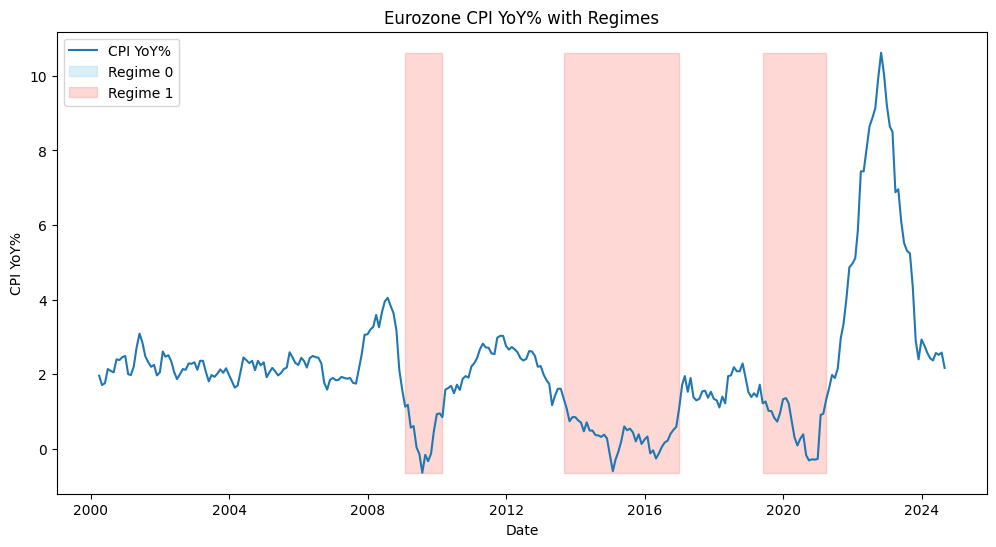

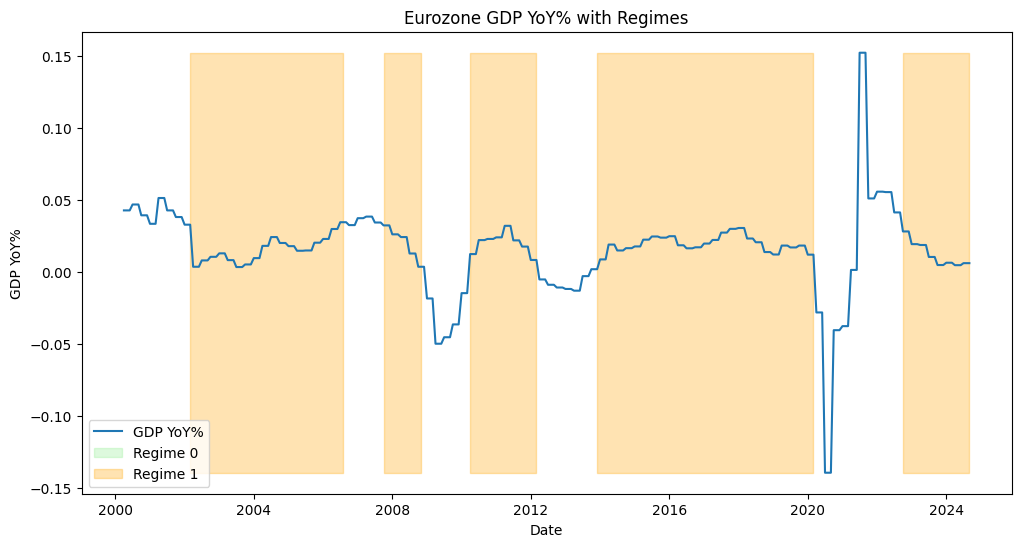

In [111]:
import matplotlib.pyplot as plt

# For CPI Data
plt.figure(figsize=(12, 6))
plt.plot(store["Eurozone"]['Period'], store["Eurozone"]['CPI_YoY%'], label='CPI YoY%')
plt.fill_between(store["Eurozone"]['Period'], 
                 store["Eurozone"]['CPI_YoY%'].min(), store["Eurozone"]['CPI_YoY%'].max(),
                 where=store["Eurozone"]['Inflation_Regime'] == 0, color='skyblue', alpha=0.3, label='Regime 0')
plt.fill_between(store["Eurozone"]['Period'], 
                 store["Eurozone"]['CPI_YoY%'].min(), store["Eurozone"]['CPI_YoY%'].max(),
                 where=store["Eurozone"]['Inflation_Regime'] == 1, color='salmon', alpha=0.3, label='Regime 1')
plt.legend()
plt.title('Eurozone CPI YoY% with Regimes')
plt.xlabel('Date')
plt.ylabel('CPI YoY%')
plt.show()

# For GDP Data
plt.figure(figsize=(12, 6))
plt.plot(store["Eurozone"]['Period'], store["Eurozone"]['GDP_YoY%'], label='GDP YoY%')
plt.fill_between(store["Eurozone"]['Period'], 
                 store["Eurozone"]['GDP_YoY%'].min(), store["Eurozone"]['GDP_YoY%'].max(),
                 where=store["Eurozone"]['Growth_Regime'] == 0, color='lightgreen', alpha=0.3, label='Regime 0')
plt.fill_between(store["Eurozone"]['Period'], 
                 store["Eurozone"]['GDP_YoY%'].min(), store["Eurozone"]['GDP_YoY%'].max(),
                 where=store["Eurozone"]['Growth_Regime'] == 1, color='orange', alpha=0.3, label='Regime 1')
plt.legend()
plt.title('Eurozone GDP YoY% with Regimes')
plt.xlabel('Date')
plt.ylabel('GDP YoY%')
plt.show()

In [112]:
# For Inflation Model
print("Inflation Model Transition Probabilities:")
print(inflation_result.params[["p[0->0]", "p[1->0]"]])

# For Growth Model
print("Growth Model Transition Probabilities:")
print(growth_result.params[["p[0->0]", "p[1->0]"]])

Inflation Model Transition Probabilities:
p[0->0]    0.957223
p[1->0]    0.013092
dtype: float64
Growth Model Transition Probabilities:
p[0->0]    0.974824
p[1->0]    0.043583
dtype: float64


In [113]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

# For Inflation Model Residuals
inflation_resid = inflation_result.resid.dropna()

# Autocorrelation Test
lb_stat, lb_pvalue = acorr_ljungbox(inflation_resid, lags=[10], return_df=False)
print('Inflation Residuals Ljung-Box Test p-value:', lb_pvalue)

# Normality Test
stat, p = shapiro(inflation_resid)
print('Inflation Residuals Shapiro-Wilk Test p-value:', p)

# For Growth Model Residuals
growth_resid = growth_result.resid.dropna()

# Autocorrelation Test
lb_stat, lb_pvalue = acorr_ljungbox(growth_resid, lags=[10], return_df=False)
print('Growth Residuals Ljung-Box Test p-value:', lb_pvalue)

# Normality Test
stat, p = shapiro(growth_resid)
print('Growth Residuals Shapiro-Wilk Test p-value:', p)

Inflation Residuals Ljung-Box Test p-value: lb_pvalue
Inflation Residuals Shapiro-Wilk Test p-value: 3.9725970873924375e-25
Growth Residuals Ljung-Box Test p-value: lb_pvalue
Growth Residuals Shapiro-Wilk Test p-value: 2.7525841626080186e-18


In [114]:
store["Eurozone"]

,Period,GDP_YoY%,CPI_YoY%,Low_Inf_Prob,High_Inf_Prob,Inflation_Regime,Low_Growth_Prob,High_Growth_Prob,Growth_Regime,Inflation_Regime_Prob_0,Inflation_Regime_Prob_1,Growth_Regime_Prob_0,Growth_Regime_Prob_1
0,2000-03-31,0.0426,1.96,9.190478e-04,0.999081,2,0.002483,0.997517,2,9.190478e-04,0.999081,0.002483,0.997517
1,2000-04-30,0.0426,1.71,3.237920e-04,0.999676,2,0.000196,0.999804,2,3.237920e-04,0.999676,0.000196,0.999804
2,2000-05-31,0.0426,1.76,1.436687e-04,0.999856,2,0.000073,0.999927,2,1.436687e-04,0.999856,0.000073,0.999927
3,2000-06-30,0.0467,2.14,1.352106e-05,0.999986,2,0.000012,0.999988,2,1.352106e-05,0.999986,0.000012,0.999988
4,2000-07-31,0.0467,2.09,1.542658e-05,0.999985,2,0.000011,0.999989,2,1.542658e-05,0.999985,0.000011,0.999989
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2024-04-30,0.0046,2.37,2.229501e-06,0.999998,2,0.994415,0.005585,1,2.229501e-06,0.999998,0.994415,0.005585
290,2024-05-31,0.0046,2.57,4.945879e-07,1.000000,2,0.993032,0.006968,1,4.945879e-07,1.000000,0.993032,0.006968
291,2024-06-30,0.0060,2.52,7.278651e-07,0.999999,2,0.991166,0.008834,1,7.278651e-07,0.999999,0.991166,0.008834
292,2024-07-31,0.0060,2.58,6.106611e-07,0.999999,2,0.986168,0.013832,1,6.106611e-07,0.999999,0.986168,0.013832


In [115]:
filtered_rows = store["Eurozone"][store["Eurozone"]['Growth_Regime'] == 1]

print(filtered_rows.count())

Period                     192
GDP_YoY%                   192
CPI_YoY%                   192
Low_Inf_Prob               192
High_Inf_Prob              192
Inflation_Regime           192
Low_Growth_Prob            192
High_Growth_Prob           192
Growth_Regime              192
Inflation_Regime_Prob_0    192
Inflation_Regime_Prob_1    192
Growth_Regime_Prob_0       192
Growth_Regime_Prob_1       192
dtype: int64


In [116]:
def assign_regime(row):
    if row['Inflation_Regime'] == 1 and row['Growth_Regime'] == 1:
        return 1  # Low Inflation, Low Growth
    elif row['Inflation_Regime'] == 1 and row['Growth_Regime'] == 2:
        return 2  # Low Inflation, High Growth
    elif row['Inflation_Regime'] == 2 and row['Growth_Regime'] == 1:
        return 3  # High Inflation, Low Growth
    else:
        return 4  # High Inflation, High Growth

store["Eurozone"]['Combined_Regime'] = store["Eurozone"].apply(assign_regime, axis=1)


In [117]:
store["Eurozone"]=store["Eurozone"].drop(["Low_Inf_Prob",	"High_Inf_Prob", "Low_Growth_Prob",	"High_Growth_Prob", "Inflation_Regime_Prob_0",	"Inflation_Regime_Prob_1",	"Growth_Regime_Prob_0",	"Growth_Regime_Prob_1","Inflation_Regime",	"Growth_Regime"], axis =1)

In [118]:
store["Eurozone"].to_csv("../Data CSV/EurozoneMarkov", sep=',', index=False, encoding='utf-8')

In [119]:
inflation_model = MarkovRegression(store["Switzerland"]['CPI_YoY%'], k_regimes=2, trend='c', switching_variance=True)
inflation_result = inflation_model.fit()

print("Inflation Model Summary:")
print(inflation_result.summary())

# Step 3: Extract Inflation Regime Probabilities
store["Switzerland"]['Low_Inf_Prob'] = inflation_result.smoothed_marginal_probabilities[0]
store["Switzerland"]['High_Inf_Prob'] = inflation_result.smoothed_marginal_probabilities[1]

# Assign Inflation Regimes based on higher probability
store["Switzerland"]['Inflation_Regime'] = np.where( store["Switzerland"]['Low_Inf_Prob'] > store["Switzerland"]['High_Inf_Prob'], 1, 2)

growth_model = MarkovRegression(store["Switzerland"]['GDP_YoY%'], k_regimes=2, trend='c', switching_variance=True)
growth_result = growth_model.fit()

print("Growth Model Summary:")
print(growth_result.summary())

# Step 3: Extract Inflation Regime Probabilities
store["Switzerland"]['Low_Growth_Prob'] = growth_result.smoothed_marginal_probabilities[0]
store["Switzerland"]['High_Growth_Prob'] = growth_result.smoothed_marginal_probabilities[1]

# Assign Inflation Regimes based on higher probability
store["Switzerland"]['Growth_Regime'] = np.where( store["Switzerland"]['Low_Growth_Prob'] > store["Switzerland"]['High_Growth_Prob'], 1, 2)
# Extract smoothed probabilities
inflation_smoothed_probs = inflation_result.smoothed_marginal_probabilities
growth_smoothed_probs = growth_result.smoothed_marginal_probabilities

# Add to DataFrame
store["Switzerland"]['Inflation_Regime_Prob_0'] = inflation_smoothed_probs[0]
store["Switzerland"]['Inflation_Regime_Prob_1'] = inflation_smoothed_probs[1]

store["Switzerland"]['Growth_Regime_Prob_0'] = growth_smoothed_probs[0]
store["Switzerland"]['Growth_Regime_Prob_1'] = growth_smoothed_probs[1]

def assign_regime(row):
    if row['Inflation_Regime'] == 1 and row['Growth_Regime'] == 1:
        return 1  # Low Inflation, Low Growth
    elif row['Inflation_Regime'] == 1 and row['Growth_Regime'] == 2:
        return 2  # Low Inflation, High Growth
    elif row['Inflation_Regime'] == 2 and row['Growth_Regime'] == 1:
        return 3  # High Inflation, Low Growth
    else:
        return 4  # High Inflation, High Growth

store["Switzerland"]['Combined_Regime'] = store["Switzerland"].apply(assign_regime, axis=1)
store["Switzerland"]=store["Switzerland"].drop(["Low_Inf_Prob",	"High_Inf_Prob", "Low_Growth_Prob",	"High_Growth_Prob", "Inflation_Regime_Prob_0",	"Inflation_Regime_Prob_1",	"Growth_Regime_Prob_0",	"Growth_Regime_Prob_1","Inflation_Regime",	"Growth_Regime"], axis =1)

store["Switzerland"].to_csv("../Data CSV/SwitzerlandMarkov", sep=',', index=False, encoding='utf-8')

Inflation Model Summary:
                        Markov Switching Model Results                        
Dep. Variable:               CPI_YoY%   No. Observations:                  294
Model:               MarkovRegression   Log Likelihood                -359.448
Date:                Thu, 14 Nov 2024   AIC                            730.896
Time:                        23:11:34   BIC                            752.998
Sample:                             0   HQIC                           739.747
                                - 294                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8667      0.042     20.510      0.000       0.784       0.950
sigma2         0.2138      

In [120]:
inflation_model = MarkovRegression(store["USA"]['CPI_YoY%'], k_regimes=2, trend='c', switching_variance=True)
inflation_result = inflation_model.fit()

print("Inflation Model Summary:")
print(inflation_result.summary())

# Step 3: Extract Inflation Regime Probabilities
store["USA"]['Low_Inf_Prob'] = inflation_result.smoothed_marginal_probabilities[0]
store["USA"]['High_Inf_Prob'] = inflation_result.smoothed_marginal_probabilities[1]

# Assign Inflation Regimes based on higher probability
store["USA"]['Inflation_Regime'] = np.where( store["USA"]['Low_Inf_Prob'] > store["USA"]['High_Inf_Prob'], 1, 2)

growth_model = MarkovRegression(store["USA"]['GDP_YoY%'], k_regimes=2, trend='c', switching_variance=True)
growth_result = growth_model.fit()

print("Growth Model Summary:")
print(growth_result.summary())

# Step 3: Extract Inflation Regime Probabilities
store["USA"]['Low_Growth_Prob'] = growth_result.smoothed_marginal_probabilities[0]
store["USA"]['High_Growth_Prob'] = growth_result.smoothed_marginal_probabilities[1]

# Assign Inflation Regimes based on higher probability
store["USA"]['Growth_Regime'] = np.where( store["USA"]['Low_Growth_Prob'] > store["USA"]['High_Growth_Prob'], 1, 2)
# Extract smoothed probabilities
inflation_smoothed_probs = inflation_result.smoothed_marginal_probabilities
growth_smoothed_probs = growth_result.smoothed_marginal_probabilities

# Add to DataFrame
store["USA"]['Inflation_Regime_Prob_0'] = inflation_smoothed_probs[0]
store["USA"]['Inflation_Regime_Prob_1'] = inflation_smoothed_probs[1]

store["USA"]['Growth_Regime_Prob_0'] = growth_smoothed_probs[0]
store["USA"]['Growth_Regime_Prob_1'] = growth_smoothed_probs[1]

def assign_regime(row):
    if row['Inflation_Regime'] == 1 and row['Growth_Regime'] == 1:
        return 1  # Low Inflation, Low Growth
    elif row['Inflation_Regime'] == 1 and row['Growth_Regime'] == 2:
        return 2  # Low Inflation, High Growth
    elif row['Inflation_Regime'] == 2 and row['Growth_Regime'] == 1:
        return 3  # High Inflation, Low Growth
    else:
        return 4  # High Inflation, High Growth

store["USA"]['Combined_Regime'] = store["USA"].apply(assign_regime, axis=1)
store["USA"]=store["USA"].drop(["Low_Inf_Prob",	"High_Inf_Prob", "Low_Growth_Prob",	"High_Growth_Prob", "Inflation_Regime_Prob_0",	"Inflation_Regime_Prob_1",	"Growth_Regime_Prob_0",	"Growth_Regime_Prob_1","Inflation_Regime",	"Growth_Regime"], axis =1)

store["USA"].to_csv("../Data CSV/USAMarkov", sep=',', index=False, encoding='utf-8')

Inflation Model Summary:
                        Markov Switching Model Results                        
Dep. Variable:               CPI_YoY%   No. Observations:                  294
Model:               MarkovRegression   Log Likelihood                -482.744
Date:                Thu, 14 Nov 2024   AIC                            977.488
Time:                        23:11:34   BIC                            999.590
Sample:                             0   HQIC                           986.339
                                - 294                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5968      0.079     20.340      0.000       1.443       1.751
sigma2         0.8823      

In [9]:
import numpy as np
from scipy.stats import gamma, dirichlet, norm

def bayesian_hmm_gibbs_sampler(Y, K, num_iter, burn_in):
    T = len(Y)
    
    # Hyperparameters
    alpha = np.ones(K)  # For initial state distribution
    beta = np.ones((K, K))  # For transition probabilities
    mu_0 = 0
    sigma_0_squared = 10**2
    a_0 = 1
    b_0 = 1

    # Initial values
    pi = dirichlet.rvs(alpha)[0]
    A = np.array([dirichlet.rvs(beta_row)[0] for beta_row in beta])
    mu = np.random.normal(mu_0, np.sqrt(sigma_0_squared), size=K)
    sigma_squared = 1 / gamma.rvs(a_0, scale=1/b_0, size=K)
    S = np.random.choice(K, size=T)

    # Storage for samples
    samples = {
        'pi': [],
        'A': [],
        'mu': [],
        'sigma_squared': [],
        'S': []
    }

    for it in range(num_iter):
        # 1. Sample Hidden States S using Forward-Backward and Backward Sampling
        alpha_t = np.zeros((T, K))
        beta_t = np.zeros((T, K))
        scale_factors = np.zeros(T)

        # Forward pass
        for t in range(T):
            if t == 0:
                alpha_t[t] = pi * norm.pdf(Y[t], mu, np.sqrt(sigma_squared))
            else:
                alpha_t[t] = (alpha_t[t-1] @ A) * norm.pdf(Y[t], mu, np.sqrt(sigma_squared))
            # Normalize
            scale = np.sum(alpha_t[t])
            alpha_t[t] /= scale
            scale_factors[t] = scale

        # Backward pass
        beta_t[T-1] = 1
        for t in range(T-2, -1, -1):
            beta_t[t] = (A @ (norm.pdf(Y[t+1], mu, np.sqrt(sigma_squared)) * beta_t[t+1]))
            beta_t[t] /= np.sum(beta_t[t])

        # Sample S_t
        S_t_prob = alpha_t * beta_t
        S_t_prob /= np.sum(S_t_prob, axis=1, keepdims=True)
        S = np.array([np.random.choice(K, p=S_t_prob[t]) for t in range(T)])

        # 2. Sample Parameters
        # Sample pi
        m = np.zeros(K)
        m[S[0]] += 1
        pi = dirichlet.rvs(alpha + m)[0]

        # Sample A
        n_ij = np.zeros((K, K))
        for t in range(1, T):
            n_ij[S[t-1], S[t]] += 1
        for i in range(K):
            A[i] = dirichlet.rvs(beta[i] + n_ij[i])[0]

        # Sample mu and sigma_squared
        for j in range(K):
            Y_j = Y[S == j]
            n_j = len(Y_j)
            if n_j > 0:
                mean_Y_j = np.mean(Y_j)
                sum_squared_diff = np.sum((Y_j - mean_Y_j)**2)

                a_post = a_0 + n_j / 2
                b_post = b_0 + 0.5 * np.sum((Y_j - mu[j])**2)
                sigma_squared[j] = 1 / gamma.rvs(a_post, scale=1/b_post)

                sigma_mu_j_squared = 1 / (n_j / sigma_squared[j] + 1 / sigma_0_squared)
                mu_j_mean = sigma_mu_j_squared * (n_j * mean_Y_j / sigma_squared[j] + mu_0 / sigma_0_squared)
                mu[j] = np.random.normal(mu_j_mean, np.sqrt(sigma_mu_j_squared))
            else:
                sigma_squared[j] = 1 / gamma.rvs(a_0, scale=1/b_0)
                mu[j] = np.random.normal(mu_0, np.sqrt(sigma_0_squared))

        # Store samples after burn-in
        if it >= burn_in:
            samples['pi'].append(pi.copy())
            samples['A'].append(A.copy())
            samples['mu'].append(mu.copy())
            samples['sigma_squared'].append(sigma_squared.copy())
            samples['S'].append(S.copy())

    return samples

In [10]:
# Example usage:
Y = store["Eurozone"]['CPI_YoY%'].values
K = 2
num_iter = 5000
burn_in = 1000

samples = bayesian_hmm_gibbs_sampler(Y, K, num_iter, burn_in)
num_samples = len(samples['S'])
T = len(Y)

# Initialize an array to store predicted Y_t for each sample
Y_pred_samples = np.zeros((num_samples, T))

for s in range(num_samples):
    mu_s = samples['mu'][s]  # Emission means for sample s (array of shape (K,))
    S_s = samples['S'][s]    # Hidden states for sample s (array of shape (T,))
    # Predicted values for sample s
    Y_pred_samples[s, :] = mu_s[S_s]
    
# Compute the posterior predictive mean for each time point
Y_pred_mean = np.mean(Y_pred_samples, axis=0)

# Compute residuals
residuals = Y - Y_pred_mean
residuals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(T), residuals, marker='o')
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.axhline(0, color='red', linestyle='--')
plt.show()
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, density=True, alpha=0.7, color='skyblue')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Density')
plt.show()
import scipy.stats as stats

plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(Y_pred_mean, residuals)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.show()
# Convert lists to NumPy arrays
pi_samples = np.array(samples['pi'])          # Shape: (num_samples, K)
A_samples = np.array(samples['A'])            # Shape: (num_samples, K, K)
mu_samples = np.array(samples['mu'])          # Shape: (num_samples, K)
sigma_squared_samples = np.array(samples['sigma_squared'])  # Shape: (num_samples, K)
S_samples = np.array(samples['S'])            # Shape: (num_samples, T)
# Number of samples after burn-in
num_samples = pi_samples.shape[0]
K = mu_samples.shape[1]

# Initialize dictionaries to store results
posterior_means = {}
credible_intervals = {}

# For each parameter
posterior_means['pi'] = np.mean(pi_samples, axis=0)
posterior_means['A'] = np.mean(A_samples, axis=0)
posterior_means['mu'] = np.mean(mu_samples, axis=0)
posterior_means['sigma_squared'] = np.mean(sigma_squared_samples, axis=0)

# Compute 95% credible intervals
credible_intervals['pi'] = np.percentile(pi_samples, [2.5, 97.5], axis=0)
credible_intervals['A'] = np.percentile(A_samples, [2.5, 97.5], axis=0)
credible_intervals['mu'] = np.percentile(mu_samples, [2.5, 97.5], axis=0)
credible_intervals['sigma_squared'] = np.percentile(sigma_squared_samples, [2.5, 97.5], axis=0)
# Function to print the results neatly
def print_posterior_estimates():
    print("Posterior Estimates:")
    print("--------------------")
    # Initial State Distribution
    print("Initial State Distribution (pi):")
    for k in range(K):
        print(f"State {k+1}: Mean = {posterior_means['pi'][k]:.4f}, 95% CI = [{credible_intervals['pi'][0][k]:.4f}, {credible_intervals['pi'][1][k]:.4f}]")
    print("\nTransition Matrix (A):")
    for i in range(K):
        for j in range(K):
            print(f"A[{i+1}][{j+1}]: Mean = {posterior_means['A'][i][j]:.4f}, 95% CI = [{credible_intervals['A'][0][i][j]:.4f}, {credible_intervals['A'][1][i][j]:.4f}]")
    print("\nEmission Means (mu):")
    for k in range(K):
        print(f"State {k+1}: Mean = {posterior_means['mu'][k]:.4f}, 95% CI = [{credible_intervals['mu'][0][k]:.4f}, {credible_intervals['mu'][1][k]:.4f}]")
    print("\nEmission Variances (sigma_squared):")
    for k in range(K):
        print(f"State {k+1}: Mean = {posterior_means['sigma_squared'][k]:.4f}, 95% CI = [{credible_intervals['sigma_squared'][0][k]:.4f}, {credible_intervals['sigma_squared'][1][k]:.4f}]")

print_posterior_estimates()
# Function to plot trace plots
def plot_trace(parameter_samples, parameter_name, state_labels):
    num_states = parameter_samples.shape[1]
    fig, axes = plt.subplots(num_states, 1, figsize=(12, 2*num_states), sharex=True)
    if num_states == 1:
        axes = [axes]
    for k in range(num_states):
        axes[k].plot(parameter_samples[:, k])
        axes[k].set_title(f'Trace Plot of {parameter_name} for State {state_labels[k]}')
        axes[k].set_xlabel('Iteration')
        axes[k].set_ylabel(f'{parameter_name}')
    plt.tight_layout()
    plt.show()

state_labels = [str(k+1) for k in range(K)]
# Plot trace plots for mu
plot_trace(mu_samples, 'mu', state_labels)
# Plot trace plots for sigma_squared
plot_trace(sigma_squared_samples, 'sigma_squared', state_labels)
# Function to plot histograms
def plot_posterior_histogram(parameter_samples, parameter_name, state_labels):
    num_states = parameter_samples.shape[1]
    fig, axes = plt.subplots(1, num_states, figsize=(4*num_states, 4))
    if num_states == 1:
        axes = [axes]
    for k in range(num_states):
        axes[k].hist(parameter_samples[:, k], bins=30, density=True, alpha=0.7, color='skyblue')
        axes[k].set_title(f'Posterior of {parameter_name} for State {state_labels[k]}')
        axes[k].set_xlabel(f'{parameter_name}')
        axes[k].set_ylabel('Density')
    plt.tight_layout()
    plt.show()

# Plot posterior histograms for mu
plot_posterior_histogram(mu_samples, 'mu', state_labels)
# Plot posterior histograms for sigma_squared
plot_posterior_histogram(sigma_squared_samples, 'sigma_squared', state_labels)
# Number of time points
T = S_samples.shape[1]

# Initialize an array to hold state probabilities
state_probs = np.zeros((T, K))

# For each time point, compute the fraction of samples where S_t = k
for t in range(T):
    for k in range(K):
        state_probs[t, k] = np.mean(S_samples[:, t] == k)

# Plot the state probabilities over time
def plot_state_probabilities(state_probs, dates, state_labels):
    plt.figure(figsize=(12, 6))
    for k in range(K):
        plt.plot(dates, state_probs[:, k], label=f'State {state_labels[k]}')
    plt.title('Posterior State Probabilities Over Time')
    plt.xlabel('Date')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

# Assuming you have a 'Period' column with dates
dates = store["Eurozone"]['Period'].values[:T]  # Ensure dates match the length T

plot_state_probabilities(state_probs, dates, state_labels)
# Determine the most probable state at each time point
most_probable_states = np.argmax(state_probs, axis=1)

# Map state indices to labels (if necessary)
state_labels = [f'State {k+1}' for k in range(K)]
state_sequence = [state_labels[state] for state in most_probable_states]

# Plot the most probable state sequence over time
def plot_most_probable_states(most_probable_states, dates, state_labels):
    plt.figure(figsize=(12, 4))
    plt.plot(dates, most_probable_states + 1, drawstyle='steps-post')
    plt.yticks(range(1, K+1), state_labels)
    plt.title('Most Probable State Sequence Over Time')
    plt.xlabel('Date')
    plt.ylabel('State')
    plt.show()

plot_most_probable_states(most_probable_states, dates, state_labels)
# Compute the posterior mean of the transition matrix
A_mean = posterior_means['A']

print("Estimated Transition Matrix (A):")
for i in range(K):
    for j in range(K):
        print(f"P(State {i+1} -> State {j+1}) = {A_mean[i][j]:.4f}")

# Visualize the transition matrix as a heatmap
import seaborn as sns

def plot_transition_matrix(A_mean, state_labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(A_mean, annot=True, cmap='Blues', fmt='.4f',
                xticklabels=state_labels, yticklabels=state_labels)
    plt.title('Estimated Transition Matrix')
    plt.xlabel('To State')
    plt.ylabel('From State')
    plt.show()

plot_transition_matrix(A_mean, state_labels)
import matplotlib.pyplot as plt
import pandas as pd

# Example events with start and end dates
events = [
    {'name': 'Dot-com Bubble Burst', 'start': '2000-03-01', 'end': '2001-11-01'},
    {'name': 'Global Financial Crisis', 'start': '2007-12-01', 'end': '2009-06-01'},
    {'name': 'European Debt Crisis', 'start': '2010-12-01', 'end': '2012-06-01'},
    {'name': 'Covid-19', 'start': '2020-03-01', 'end': '2022-01-01'}
    # Add more events as needed
]

# Define a list of colors to cycle through for each event
event_colors = ['lightcoral', 'lightblue', 'lightgreen', 'khaki', 'plum']  # Add more colors if needed

def plot_state_probabilities_with_events(state_probs, dates, state_labels, events):
    plt.figure(figsize=(12, 6))
    
    # Plot state probabilities
    for k in range(len(state_labels)):
        plt.plot(dates, state_probs[:, k], label=f'State {state_labels[k]}')
    
    # Plot events with different colors
    for i, event in enumerate(events):
        color = event_colors[i % len(event_colors)]  # Cycle through colors if more events than colors
        plt.axvspan(pd.to_datetime(event['start']), pd.to_datetime(event['end']),
                    color=color, alpha=0.3, label=event['name'])
    
    plt.title('Posterior State Probabilities Over Time with Economic Events')
    plt.xlabel('Date')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

plot_state_probabilities_with_events(state_probs, dates, state_labels, events)
# Generate synthetic data using posterior samples
def generate_synthetic_data(mu_samples, sigma_squared_samples, S_samples):
    num_samples = mu_samples.shape[0]
    T = S_samples.shape[1]
    synthetic_Y = np.zeros((num_samples, T))
    for i in range(num_samples):
        mu = mu_samples[i]
        sigma = np.sqrt(sigma_squared_samples[i])
        S = S_samples[i]
        for t in range(T):
            state = S[t]
            synthetic_Y[i, t] = np.random.normal(mu[state], sigma[state])
    return synthetic_Y

synthetic_Y = generate_synthetic_data(mu_samples, sigma_squared_samples, S_samples)

# Compare observed data with synthetic data
def plot_posterior_predictive_check(Y_observed, synthetic_Y, dates):
    plt.figure(figsize=(12, 6))
    # Plot observed data
    plt.plot(dates, Y_observed, label='Observed Data', color='black')
    # Plot a range (e.g., 95% credible interval) of synthetic data
    lower = np.percentile(synthetic_Y, 2.5, axis=0)
    upper = np.percentile(synthetic_Y, 97.5, axis=0)
    plt.fill_between(dates, lower, upper, color='skyblue', alpha=0.5, label='95% Predictive Interval')
    plt.title('Posterior Predictive Check')
    plt.xlabel('Date')
    plt.ylabel('CPI YoY%')
    plt.legend()
    plt.show()

Y_observed = Y[:T]  # Ensure Y_observed matches length T
plot_posterior_predictive_check(Y_observed, synthetic_Y, dates)


KeyboardInterrupt: 

In [ ]:
# import numpy as np
# from scipy.stats import norm, invgamma, skewnorm, dirichlet
# from scipy.special import erf

# def skew_normal_pdf(y, xi, omega, alpha):
#     t = (y - xi) / omega
#     pdf = (2 / omega) * norm.pdf(t) * norm.cdf(alpha * t)
#     return pdf
# def bayesian_hmm_with_skew_normal(Y, K, num_iter, burn_in):
#     T = len(Y)
#     # Hyperparameters
#     alpha_prior = np.ones(K)  # For initial state distribution
#     beta_prior = np.ones((K, K))  # For transition probabilities
    
#     # Priors for parameters
#     mu_xi = 0
#     sigma2_xi = 100  # Prior variance for xi_j
#     a_omega = 2
#     b_omega = 2  # Parameters for Inverse-Gamma prior on omega_j^2
#     mu_alpha = 0
#     sigma2_alpha = 10  # Prior variance for alpha_j

#     # Initial values
#     pi = dirichlet.rvs(alpha_prior)[0]
#     A = np.array([dirichlet.rvs(beta_row)[0] for beta_row in beta_prior])
#     xi = np.random.normal(mu_xi, np.sqrt(sigma2_xi), size=K)
#     omega_squared = 1 / invgamma.rvs(a_omega, scale=b_omega, size=K)
#     alpha = np.random.normal(mu_alpha, np.sqrt(sigma2_alpha), size=K)
#     S = np.random.choice(K, size=T)

#     # Proposal standard deviations
#     tau_xi = 1.0
#     tau_omega = 0.5
#     tau_alpha = 1.0

#     # Storage for samples
#     samples = {'pi': [], 'A': [], 'xi': [], 'omega_squared': [], 'alpha': [], 'S': []}

#     for it in range(num_iter):
#         # 1. Sample Hidden States S using Forward-Backward Algorithm
#         # Update alpha_t and beta_t using skew-normal PDF
#         alpha_t = np.zeros((T, K))
#         beta_t = np.zeros((T, K))
#         scale_factors = np.zeros(T)

#         # Forward pass
#         for t in range(T):
#             emission_probs = np.array([
#                 skew_normal_pdf(Y[t], xi[j], np.sqrt(omega_squared[j]), alpha[j]) for j in range(K)
#             ])
#             if t == 0:
#                 alpha_t[t] = pi * emission_probs
#             else:
#                 alpha_t[t] = (alpha_t[t-1] @ A) * emission_probs
#             # Normalize
#             scale = np.sum(alpha_t[t])
#             alpha_t[t] /= scale
#             scale_factors[t] = scale

#         # Backward pass
#         beta_t[T-1] = 1
#         for t in range(T-2, -1, -1):
#             emission_probs = np.array([
#                 skew_normal_pdf(Y[t+1], xi[j], np.sqrt(omega_squared[j]), alpha[j]) for j in range(K)
#             ])
#             beta_t[t] = (A @ (emission_probs * beta_t[t+1]))
#             beta_t[t] /= np.sum(beta_t[t])

#         # Sample S_t
#         S_t_prob = alpha_t * beta_t
#         S_t_prob /= np.sum(S_t_prob, axis=1, keepdims=True)
#         S = np.array([np.random.choice(K, p=S_t_prob[t]) for t in range(T)])

#         # 2. Sample Parameters
#         for j in range(K):
#             Y_j = Y[S == j]
#             n_j = len(Y_j)
#             if n_j > 0:
#                 # Current values
#                 xi_j_current = xi[j]
#                 omega2_j_current = omega_squared[j]
#                 alpha_j_current = alpha[j]

#                 # --- Sample xi_j using MH ---
#                 xi_j_proposal = np.random.normal(xi_j_current, tau_xi)
#                 # Log-likelihood ratio
#                 ll_current = np.sum(np.log(skew_normal_pdf(Y_j, xi_j_current, np.sqrt(omega2_j_current), alpha_j_current)))
#                 ll_proposal = np.sum(np.log(skew_normal_pdf(Y_j, xi_j_proposal, np.sqrt(omega2_j_current), alpha_j_current)))
#                 # Log-prior ratio
#                 lp_current = -0.5 * ((xi_j_current - mu_xi)**2) / sigma2_xi
#                 lp_proposal = -0.5 * ((xi_j_proposal - mu_xi)**2) / sigma2_xi
#                 # Acceptance probability
#                 log_alpha = ll_proposal + lp_proposal - ll_current - lp_current
#                 alpha_xi = min(1, np.exp(log_alpha))
#                 if np.random.uniform(0, 1) < alpha_xi:
#                     xi[j] = xi_j_proposal
#                 else:
#                     xi[j] = xi_j_current

#                 # --- Sample omega_squared_j using MH ---
#                 epsilon_omega = np.random.normal(0, tau_omega)
#                 omega2_j_proposal = np.exp(np.log(omega2_j_current) + epsilon_omega)
#                 # Jacobian adjustment
#                 log_jacobian = np.log(omega2_j_proposal) - np.log(omega2_j_current)
#                 # Log-likelihood ratio
#                 ll_current = np.sum(np.log(skew_normal_pdf(Y_j, xi[j], np.sqrt(omega2_j_current), alpha_j_current)))
#                 ll_proposal = np.sum(np.log(skew_normal_pdf(Y_j, xi[j], np.sqrt(omega2_j_proposal), alpha_j_current)))
#                 # Log-prior ratio
#                 lp_current = (-(a_omega + 1) * np.log(omega2_j_current)) - (b_omega / omega2_j_current)
#                 lp_proposal = (-(a_omega + 1) * np.log(omega2_j_proposal)) - (b_omega / omega2_j_proposal)
#                 # Acceptance probability
#                 log_alpha = ll_proposal + lp_proposal - ll_current - lp_current + log_jacobian
#                 alpha_omega = min(1, np.exp(log_alpha))
#                 if np.random.uniform(0, 1) < alpha_omega:
#                     omega_squared[j] = omega2_j_proposal
#                 else:
#                     omega_squared[j] = omega2_j_current

#                 # --- Sample alpha_j using MH ---
#                 alpha_j_proposal = np.random.normal(alpha_j_current, tau_alpha)
#                 # Log-likelihood ratio
#                 ll_current = np.sum(np.log(skew_normal_pdf(Y_j, xi[j], np.sqrt(omega_squared[j]), alpha_j_current)))
#                 ll_proposal = np.sum(np.log(skew_normal_pdf(Y_j, xi[j], np.sqrt(omega_squared[j]), alpha_j_proposal)))
#                 # Log-prior ratio
#                 lp_current = -0.5 * ((alpha_j_current - mu_alpha)**2) / sigma2_alpha
#                 lp_proposal = -0.5 * ((alpha_j_proposal - mu_alpha)**2) / sigma2_alpha
#                 # Acceptance probability
#                 log_alpha = ll_proposal + lp_proposal - ll_current - lp_current
#                 alpha_alpha = min(1, np.exp(log_alpha))
#                 if np.random.uniform(0, 1) < alpha_alpha:
#                     alpha[j] = alpha_j_proposal
#                 else:
#                     alpha[j] = alpha_j_current
#             else:
#                 # If no data assigned to state j, sample from priors
#                 xi[j] = np.random.normal(mu_xi, np.sqrt(sigma2_xi))
#                 omega_squared[j] = 1 / invgamma.rvs(a_omega, scale=b_omega)
#                 alpha[j] = np.random.normal(mu_alpha, np.sqrt(sigma2_alpha))

#         # Sample pi and A (same as before)
#         # Update counts for pi
#         m = np.zeros(K)
#         m[S[0]] += 1
#         pi = dirichlet.rvs(alpha_prior + m)[0]

#         # Update counts for A
#         n_ij = np.zeros((K, K))
#         for t in range(1, T):
#             n_ij[S[t-1], S[t]] += 1
#         for i in range(K):
#             A[i] = dirichlet.rvs(beta_prior[i] + n_ij[i])[0]

#         # Store samples after burn-in
#         if it >= burn_in:
#             samples['pi'].append(pi.copy())
#             samples['A'].append(A.copy())
#             samples['xi'].append(xi.copy())
#             samples['omega_squared'].append(omega_squared.copy())
#             samples['alpha'].append(alpha.copy())
#             samples['S'].append(S.copy())

#     return samples
# # Example usage:
# Y = store["Eurozone"]['CPI_YoY%'].values
# K = 3
# num_iter = 6000
# burn_in = 1000

# samples1 = bayesian_hmm_with_skew_normal(Y, K, num_iter, burn_in)


In [11]:
import numpy as np
from scipy.stats import norm, skewnorm

def particle_filter(Y, pi, A, emission_params, num_particles, ess_threshold=0.5):
    """
    Implements a particle filter for an HMM with ESS cutoff to prevent degeneracy.

    Parameters:
    - Y: Observed data sequence (array of length T).
    - pi: Initial state distribution (array of length K).
    - A: Transition matrix (K x K array).
    - emission_params: Dictionary containing emission parameters.
        - For Gaussian emissions: {'mu': array, 'sigma': array}
        - For skew-normal emissions: {'xi': array, 'omega': array, 'alpha': array}
    - num_particles: Number of particles to use in the filter.
    - ess_threshold: Fraction of the number of particles to trigger resampling (default is 0.5).

    Returns:
    - particles: Array of particles at each time step (T x num_particles).
    - weights: Array of weights at each time step (T x num_particles).
    - estimated_states: Estimated state sequence (array of length T).
    """
    T = len(Y)
    K = len(pi)
    particles = np.zeros((T, num_particles), dtype=int)
    weights = np.zeros((T, num_particles))
    
    # Initialize particles and weights
    particles[0] = np.random.choice(K, size=num_particles, p=pi)
    if 'mu' in emission_params:
        # Gaussian emissions
        emission_probs = norm.pdf(Y[0], loc=emission_params['mu'][particles[0]], scale=emission_params['sigma'][particles[0]])
    elif 'xi' in emission_params:
        # Skew-normal emissions
        emission_probs = skewnorm.pdf(Y[0], a=emission_params['alpha'][particles[0]],
                                      loc=emission_params['xi'][particles[0]],
                                      scale=emission_params['omega'][particles[0]])
    else:
        raise ValueError("Emission parameters are not properly defined.")
    
    weights[0] = emission_probs
    weights[0] /= np.sum(weights[0])  # Normalize weights
    
    for t in range(1, T):
        # Calculate ESS
        ess = 1.0 / np.sum(weights[t-1] ** 2)
        
        # Resample if ESS falls below the threshold
        if ess < ess_threshold * num_particles:
            indices = np.random.choice(num_particles, size=num_particles, p=weights[t-1])
            particles[t-1] = particles[t-1][indices]
            weights[t-1] = np.ones(num_particles) / num_particles  # Reset weights to uniform after resampling
        
        particles_t_minus_1 = particles[t-1]
        
        # Predict step: sample next state for each particle
        particles[t] = np.array([np.random.choice(K, p=A[particles_t_minus_1[i]]) for i in range(num_particles)])
        
        # Update weights based on observation likelihood
        if 'mu' in emission_params:
            # Gaussian emissions
            emission_probs = norm.pdf(Y[t], loc=emission_params['mu'][particles[t]], scale=emission_params['sigma'][particles[t]])
        elif 'xi' in emission_params:
            # Skew-normal emissions
            emission_probs = skewnorm.pdf(Y[t], a=emission_params['alpha'][particles[t]],
                                          loc=emission_params['xi'][particles[t]],
                                          scale=emission_params['omega'][particles[t]])
        weights[t] = emission_probs
        weights[t] /= np.sum(weights[t])  # Normalize weights
    
    # Estimate states (e.g., using the most probable particle at each time)
    estimated_states = np.zeros(T, dtype=int)
    for t in range(T):
        # You can choose different methods for state estimation
        # Here, we use the state with the highest total weight
        counts = np.bincount(particles[t], weights=weights[t])
        estimated_states[t] = np.argmax(counts)
    
    return particles, weights, estimated_states

In [179]:
# Example usage
num_particles = 1000  # Adjust the number of particles as needed
T = len(Y)

# Extract posterior means of parameters from your samples
pi_mean = np.mean(samples['pi'], axis=0)
A_mean = np.mean(samples['A'], axis=0)

if 'mu' in samples and 'sigma_squared' in samples:
    # Gaussian emissions
    mu_mean = np.mean(samples['mu'], axis=0)
    sigma_mean = np.sqrt(np.mean(samples['sigma_squared'], axis=0))
    emission_params = {'mu': mu_mean, 'sigma': sigma_mean}
elif 'xi' in samples and 'omega_squared' in samples and 'alpha' in samples:
    # Skew-normal emissions
    xi_mean = np.mean(samples['xi'], axis=0)
    omega_mean = np.sqrt(np.mean(samples['omega_squared'], axis=0))
    alpha_mean = np.mean(samples['alpha'], axis=0)
    emission_params = {'xi': xi_mean, 'omega': omega_mean, 'alpha': alpha_mean}
else:
    raise ValueError("Emission parameters are not available.")

# Run the particle filter
particles, weights, estimated_states = particle_filter(Y, pi_mean, A_mean, emission_params, num_particles)

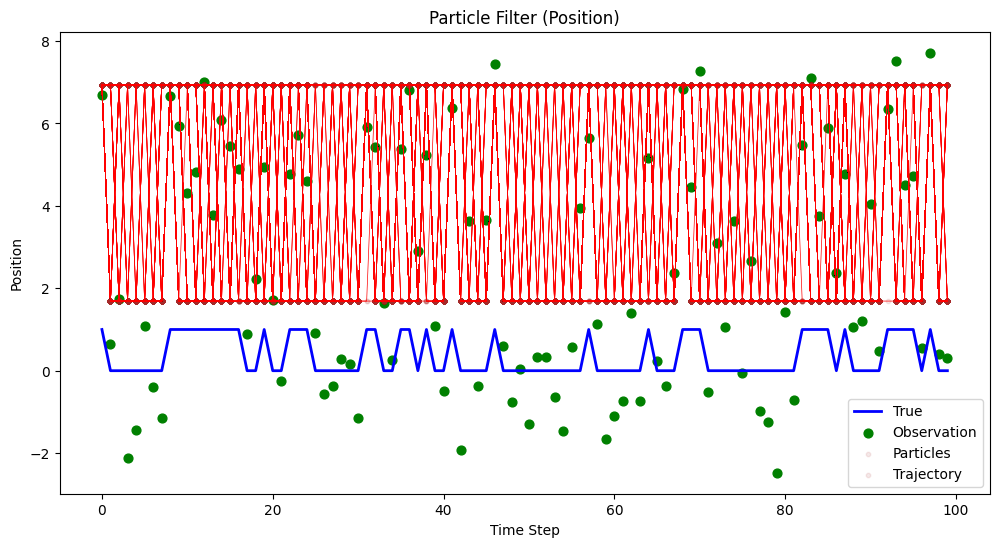

In [180]:
# Generate a trajectory for each particle over time
particle_trajectories = np.zeros((T, num_particles))
for t in range(T):
    particle_trajectories[t, :] = [emission_params['mu'][particles[t, i]] for i in range(num_particles)]

# Plotting
plt.figure(figsize=(12, 6))

# Plot the true hidden states trajectory if you have it (optional)
# If `true_states` is available, use it; otherwise, replace with `estimated_states`
plt.plot(range(T), estimated_states, label='True', color='blue', lw=2)

# Plot observed data points
plt.scatter(range(T), Y, label='Observation', color='green', s=40)

# Plot particles at each time step
for t in range(T):
    plt.scatter([t] * num_particles, particle_trajectories[t, :], color='brown', alpha=0.1, s=10)

# Plot particle trajectories
for i in range(num_particles):
    plt.plot(range(T), particle_trajectories[:, i], color='red', alpha=1, lw=0.5)

# Add labels and legend
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.title('Particle Filter (Position)')
plt.legend(['True', 'Observation', 'Particles', 'Trajectory'])
plt.show()

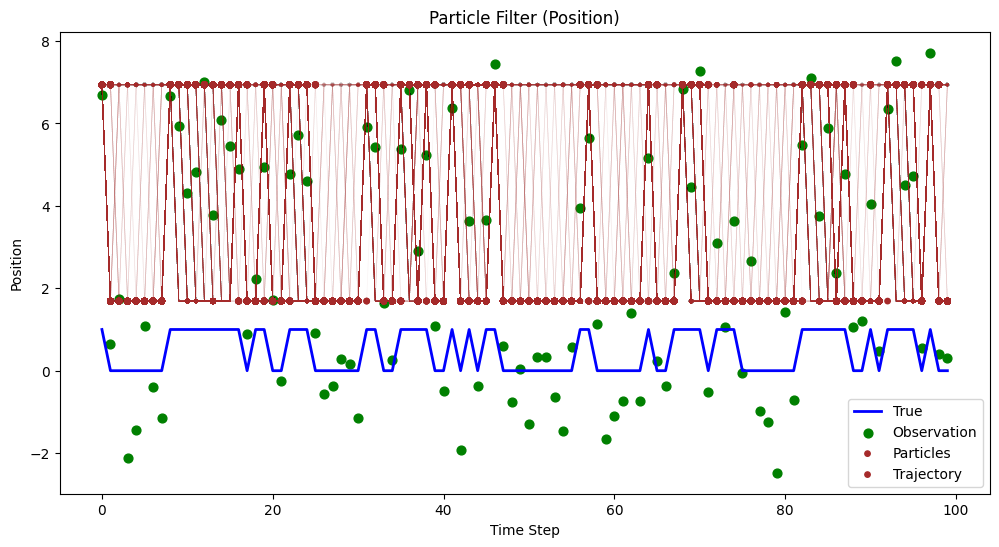

In [181]:
def plot_particle_filter(Y, true_states, estimated_states, particles, weights, emission_params):
    T, num_particles = particles.shape
    particle_trajectories = np.zeros((T, num_particles))
    
    for t in range(T):
        particle_trajectories[t, :] = [emission_params['mu'][particles[t, i]] for i in range(num_particles)]
    
    plt.figure(figsize=(12, 6))

    # Plot the true hidden states trajectory (optional)
    if true_states is not None:
        plt.plot(range(T), true_states, label='True', color='blue', lw=2)
    
    # Plot observations (Y)
    plt.scatter(range(T), Y, label='Observation', color='green', s=40)

    # Plot particles and their trajectories, highlighting higher-weight particles
    for t in range(T):
        # Normalize weights for better visualization (optional)
        normalized_weights = weights[t] / np.max(weights[t])
        
        # Scatter plot for particles at each time step with transparency and size based on weight
        plt.scatter([t] * num_particles, particle_trajectories[t, :], 
                    color='brown', alpha=normalized_weights, s=10 * normalized_weights + 5)

    # Plot particle trajectories with lower transparency to show resampling paths
    for i in range(num_particles):
        plt.plot(range(T), particle_trajectories[:, i], color='brown', alpha=0.05, lw=0.5)

    # Add labels and legend
    plt.xlabel('Time Step')
    plt.ylabel('Position')
    plt.title('Particle Filter (Position)')
    plt.legend(['True', 'Observation', 'Particles', 'Trajectory'])
    plt.show()

# Assuming you already ran the particle filter with:
# particles, weights, estimated_states = particle_filter(Y, pi_mean, A_mean, emission_params, num_particles)

# Call the plot function
plot_particle_filter(Y, true_states, estimated_states, particles, weights, emission_params)

In [176]:
estimated_states

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0])

In [177]:
particles.shape

(100, 100)

In [178]:
weights.shape

(100, 100)

In [12]:
import numpy as np
from scipy.stats import norm, skewnorm

def particle_filter_with_ess(Y, pi, A, emission_params, num_particles, ess_threshold=None):
    """
    Implements a particle filter for an HMM with ESS-based resampling.

    Parameters:
    - Y: Observed data sequence (array of length T).
    - pi: Initial state distribution (array of length K).
    - A: Transition matrix (K x K array).
    - emission_params: Dictionary containing emission parameters.
        - For Gaussian emissions: {'mu': array, 'sigma': array}
        - For skew-normal emissions: {'xi': array, 'omega': array, 'alpha': array}
    - num_particles: Number of particles to use in the filter.
    - ess_threshold: ESS threshold for resampling (float between 0 and 1).

    Returns:
    - particles: Array of particles at each time step (T x num_particles).
    - weights: Array of weights at each time step (T x num_particles).
    - estimated_states: Estimated state sequence (array of length T).
    """
    T = len(Y)
    K = len(pi)
    particles = np.zeros((T, num_particles), dtype=int)
    weights = np.zeros((T, num_particles))

    # Initialize particles and weights
    particles[0] = np.random.choice(K, size=num_particles, p=pi)
    if 'mu' in emission_params:
        # Gaussian emissions
        emission_probs = norm.pdf(Y[0], loc=emission_params['mu'][particles[0]], scale=emission_params['sigma'][particles[0]])
    elif 'xi' in emission_params:
        # Skew-normal emissions
        emission_probs = skewnorm.pdf(Y[0], a=emission_params['alpha'][particles[0]],
                                      loc=emission_params['xi'][particles[0]],
                                      scale=emission_params['omega'][particles[0]])
    else:
        raise ValueError("Emission parameters are not properly defined.")

    weights[0] = emission_probs
    weights[0] /= np.sum(weights[0])  # Normalize weights

    for t in range(1, T):
        # Compute ESS
        ess = 1.0 / np.sum(weights[t-1] ** 2)

        # Resample if ESS is below threshold
        if ess_threshold is not None and ess < ess_threshold * num_particles:
            # Resample particles based on weights
            indices = np.random.choice(num_particles, size=num_particles, p=weights[t-1])
            particles[t-1] = particles[t-1][indices]
            weights[t-1] = 1.0 / num_particles  # Reset weights
        else:
            indices = np.arange(num_particles)

        # Predict step: sample next state for each particle
        particles_t_minus_1 = particles[t-1][indices]
        particles[t] = np.array([np.random.choice(K, p=A[particles_t_minus_1[i]]) for i in range(num_particles)])

        # Update weights based on observation likelihood
        if 'mu' in emission_params:
            # Gaussian emissions
            emission_probs = norm.pdf(Y[t], loc=emission_params['mu'][particles[t]], scale=emission_params['sigma'][particles[t]])
        elif 'xi' in emission_params:
            # Skew-normal emissions
            emission_probs = skewnorm.pdf(Y[t], a=emission_params['alpha'][particles[t]],
                                          loc=emission_params['xi'][particles[t]],
                                          scale=emission_params['omega'][particles[t]])
        weights[t] = weights[t-1] * emission_probs
        weights[t] /= np.sum(weights[t])  # Normalize weights

    # Estimate states (e.g., using the most probable particle at each time)
    estimated_states = np.zeros(T, dtype=int)
    for t in range(T):
        # Compute weighted counts of states
        counts = np.zeros(K)
        for k in range(K):
            counts[k] = np.sum(weights[t][particles[t] == k])
        estimated_states[t] = np.argmax(counts)

    return particles, weights, estimated_states

In [ ]:
# Example usage
num_particles = 100000  # Adjust the number of particles as needed
T = len(Y)

# Extract posterior means of parameters from your samples
pi_mean = np.mean(samples['pi'], axis=0)
A_mean = np.mean(samples['A'], axis=0)

if 'mu' in samples and 'sigma_squared' in samples:
    # Gaussian emissions
    mu_mean = np.mean(samples['mu'], axis=0)
    sigma_mean = np.sqrt(np.mean(samples['sigma_squared'], axis=0))
    emission_params = {'mu': mu_mean, 'sigma': sigma_mean}
elif 'xi' in samples and 'omega_squared' in samples and 'alpha' in samples:
    # Skew-normal emissions
    xi_mean = np.mean(samples['xi'], axis=0)
    omega_mean = np.sqrt(np.mean(samples['omega_squared'], axis=0))
    alpha_mean = np.mean(samples['alpha'], axis=0)
    emission_params = {'xi': xi_mean, 'omega': omega_mean, 'alpha': alpha_mean}
else:
    raise ValueError("Emission parameters are not available.")

# Run the particle filter
particles, weights, estimated_states = particle_filter_with_ess(Y, pi_mean, A_mean, emission_params, num_particles)

In [154]:
def simulate_hmm(T, pi, A, emission_params):
    """
    Simulates an HMM with given parameters.

    Parameters:
    - T: Length of the time series.
    - pi: Initial state distribution (array of length K).
    - A: Transition matrix (K x K array).
    - emission_params: Emission parameters.

    Returns:
    - states: True hidden states (array of length T).
    - observations: Observed data (array of length T).
    """
    K = len(pi)
    states = np.zeros(T, dtype=int)
    observations = np.zeros(T)

    # Initial state
    states[0] = np.random.choice(K, p=pi)
    # Generate observation
    if 'mu' in emission_params:
        # Gaussian emissions
        observations[0] = np.random.normal(loc=emission_params['mu'][states[0]], scale=emission_params['sigma'][states[0]])
    elif 'xi' in emission_params:
        # Skew-normal emissions
        observations[0] = skewnorm.rvs(a=emission_params['alpha'][states[0]],
                                       loc=emission_params['xi'][states[0]],
                                       scale=emission_params['omega'][states[0]])
    else:
        raise ValueError("Emission parameters are not properly defined.")

    # Generate subsequent states and observations
    for t in range(1, T):
        states[t] = np.random.choice(K, p=A[states[t-1]])
        if 'mu' in emission_params:
            observations[t] = np.random.normal(loc=emission_params['mu'][states[t]], scale=emission_params['sigma'][states[t]])
        elif 'xi' in emission_params:
            observations[t] = skewnorm.rvs(a=emission_params['alpha'][states[t]],
                                           loc=emission_params['xi'][states[t]],
                                           scale=emission_params['omega'][states[t]])

    return states, observations

In [161]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Simulate data
T = 100
K = 2  # Number of states
pi_true = np.array([0.6, 0.4])
A_true = np.array([[0.7, 0.3],
                   [0.4, 0.6]])

# Emission parameters for Gaussian emissions
emission_params_true = {
    'mu': np.array([0, 5]),
    'sigma': np.array([1, 1.5])
}

# Simulate HMM
true_states, Y = simulate_hmm(T, pi_true, A_true, emission_params_true)

# Run particle filter
num_particles = 100000
ess_threshold = 0.5  # Resample when ESS < 50% of num_particles

# Use true parameters for filtering (in practice, you would use estimated parameters)
particles, weights, estimated_states = particle_filter_with_ess(Y, pi_true, A_true, emission_params_true, num_particles, ess_threshold)

# Evaluate performance
accuracy = accuracy_score(true_states, estimated_states)
conf_matrix = confusion_matrix(true_states, estimated_states)

print(f"Accuracy of state estimation: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy of state estimation: 97.00%
Confusion Matrix:
[[52  1]
 [ 2 45]]


In [162]:
# Compute predicted observations
predicted_observations = np.zeros(T)
for t in range(T):
    if 'mu' in emission_params_true:
        predicted_observations[t] = emission_params_true['mu'][estimated_states[t]]
    elif 'xi' in emission_params_true:
        predicted_observations[t] = emission_params_true['xi'][estimated_states[t]]

# Compute RMSE
rmse = np.sqrt(np.mean((Y - predicted_observations) ** 2))
print(f"RMSE between observed and predicted observations: {rmse:.2f}")

RMSE between observed and predicted observations: 1.25


In [165]:
import matplotlib.pyplot as plt

def plot_particles(T, particles, weights, Y, estimated_states, true_states=None, time_points=None):
    """
    Plots particles, observations, and estimated states at selected time points.

    Parameters:
    - T: Length of the time series.
    - particles: Array of particles (T x num_particles).
    - weights: Array of weights (T x num_particles).
    - Y: Observed data (array of length T).
    - estimated_states: Estimated states from the particle filter.
    - true_states: True hidden states (optional).
    - time_points: List of time points to plot (optional).
    """
    if time_points is None:
        time_points = [0, T // 4, T // 2, 3 * T // 4, T - 1]
    
    num_plots = len(time_points)
    fig, axs = plt.subplots(num_plots, 1, figsize=(10, num_plots * 3), sharex=True)

    for idx, t in enumerate(time_points):
        ax = axs[idx]
        # Plot particles
        ax.scatter([t] * particles.shape[1], particles[t], s=weights[t] * 1000, alpha=0.8, label='Particles')
        # Plot estimated state
        ax.scatter(t, estimated_states[t], color='red', marker='x', s=100, label='Estimated State')
        # Plot true state
        if true_states is not None:
            ax.scatter(t, true_states[t], color='green', marker='o', s=100, label='True State')
        # Plot observation
        ax.plot(t, Y[t], 'k*', markersize=13, label='Observation')
        ax.set_ylabel('State')
        ax.legend()
        ax.set_title(f'Time {t}')

    axs[-1].set_xlabel('Time')
    plt.tight_layout()
    plt.show()

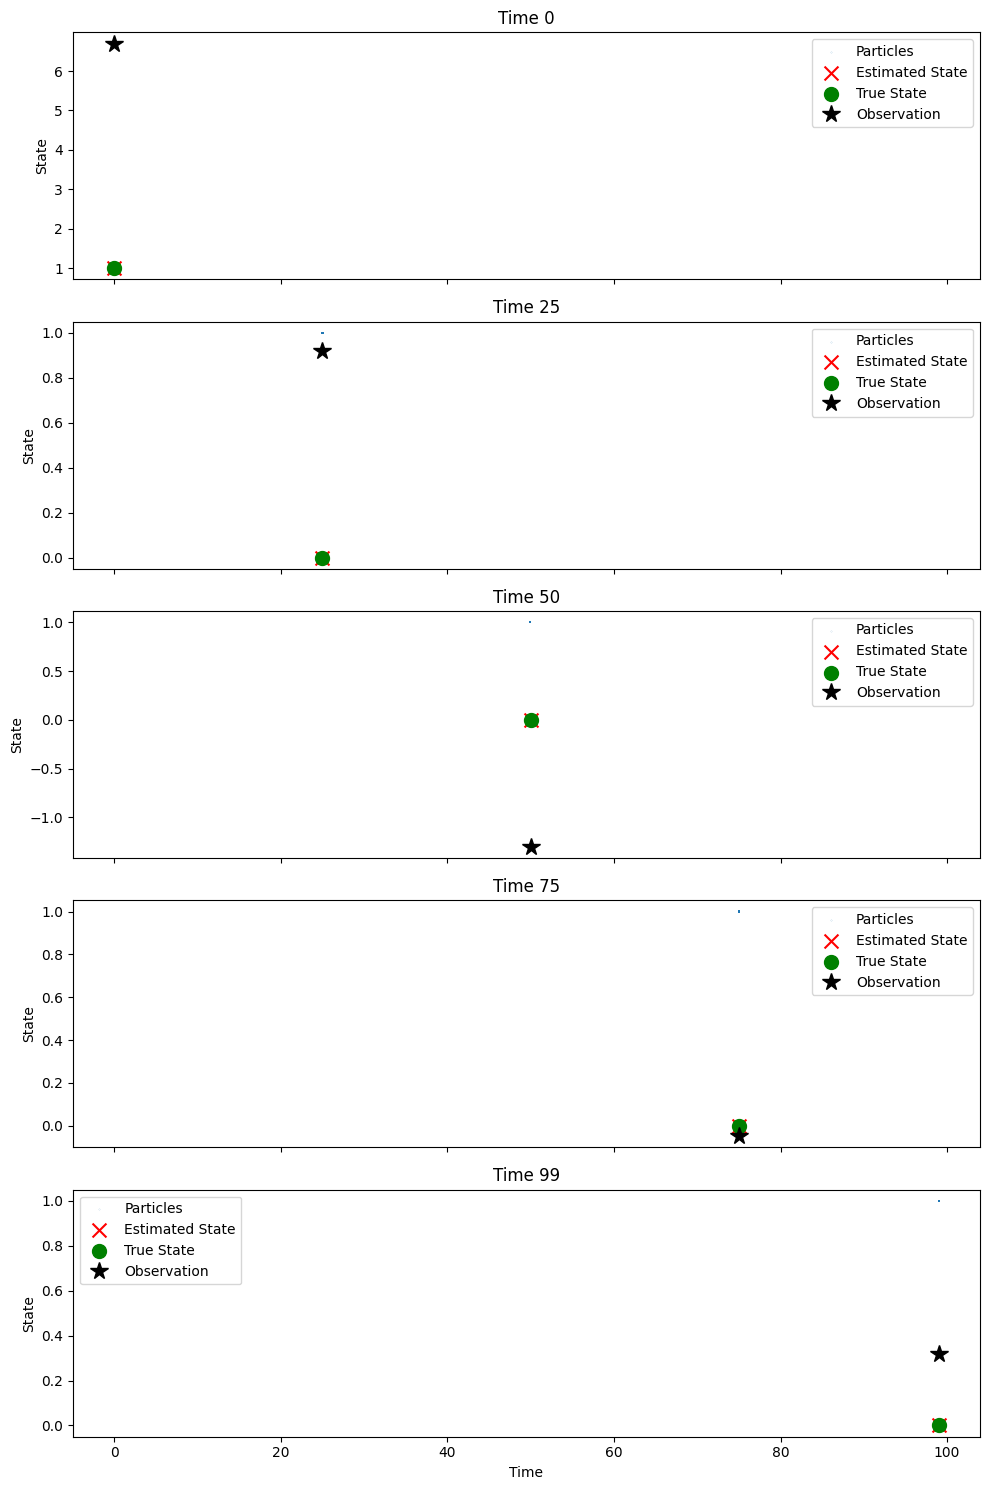

In [166]:
plot_particles(T, particles, weights, Y, estimated_states, true_states)

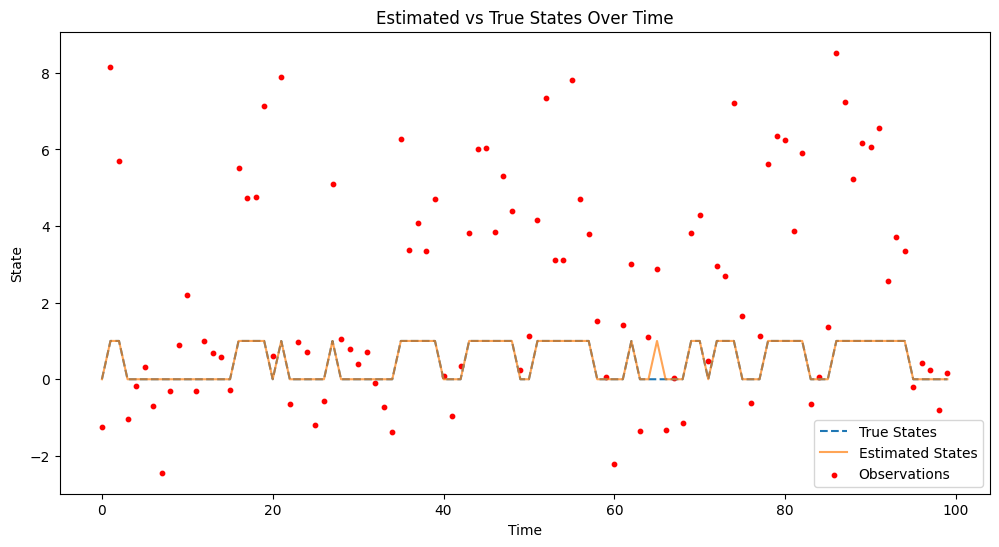

In [159]:
plt.figure(figsize=(12, 6))
plt.plot(range(T), true_states, label='True States', linestyle='--')
plt.plot(range(T), estimated_states, label='Estimated States', alpha=0.7)
plt.scatter(range(T), Y, color='red', label='Observations', s=10)
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Estimated vs True States Over Time')
plt.legend()
plt.show()

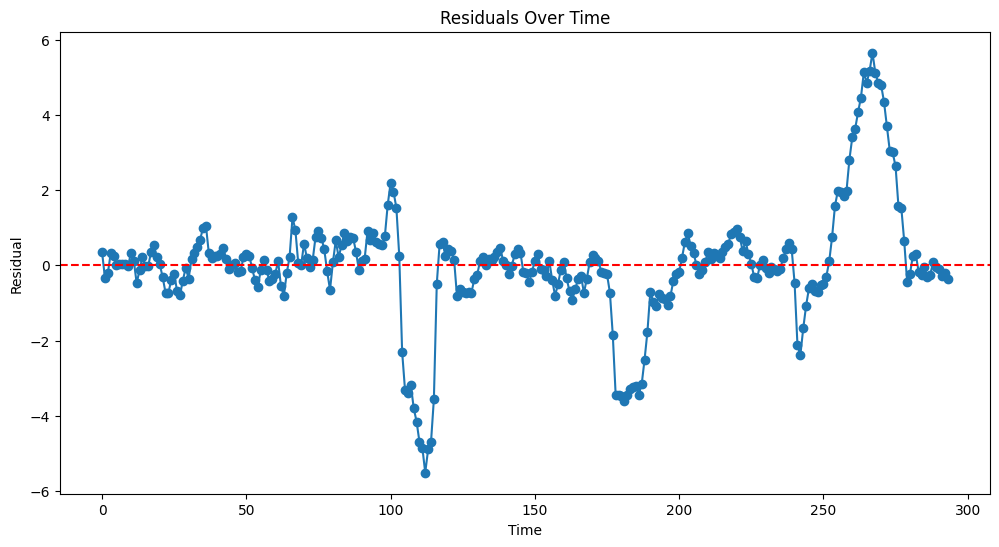

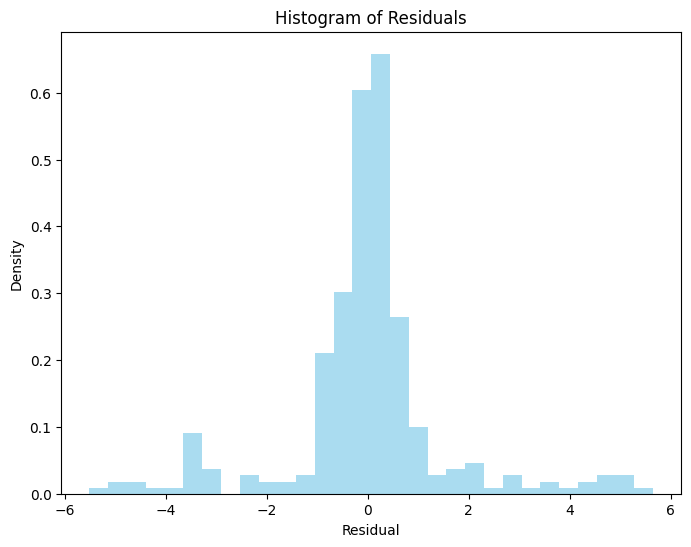

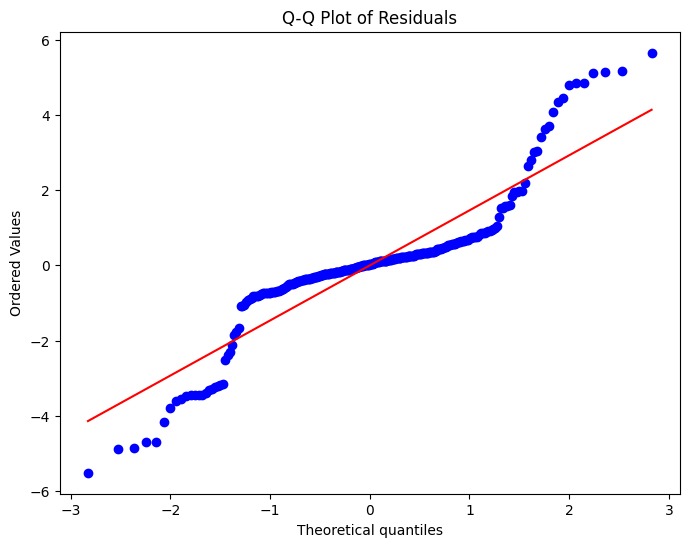

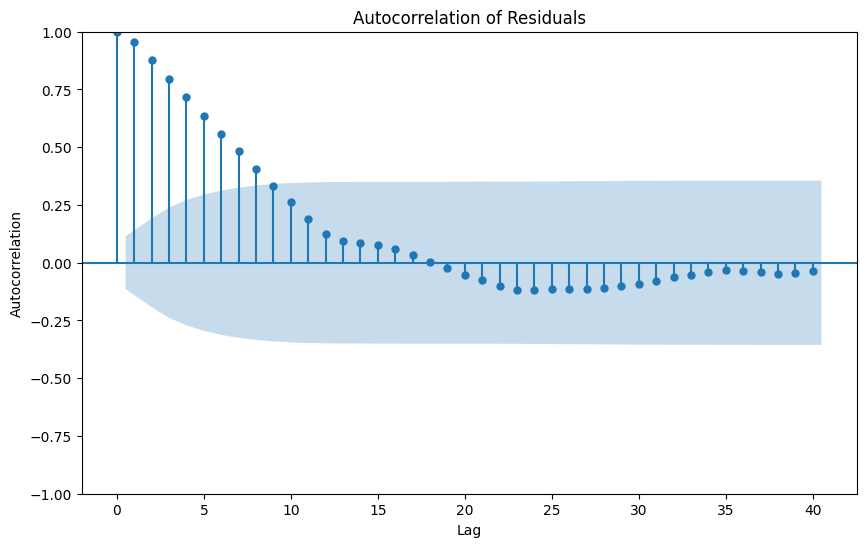

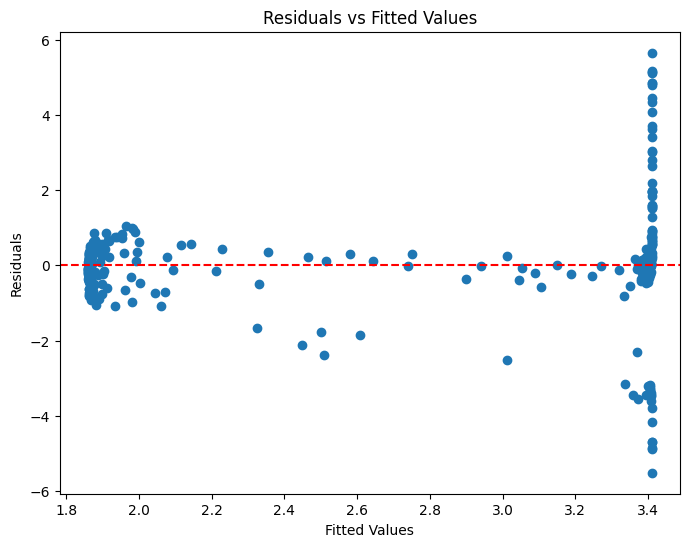

Posterior Estimates:
--------------------
Initial State Distribution (pi):
State 1: Mean = 0.3349, 95% CI = [0.0121, 0.8419]
State 2: Mean = 0.6651, 95% CI = [0.1581, 0.9879]

Transition Matrix (A):
A[1][1]: Mean = 0.9308, 95% CI = [0.8731, 0.9712]
A[1][2]: Mean = 0.0692, 95% CI = [0.0288, 0.1269]
A[2][1]: Mean = 0.0825, 95% CI = [0.0349, 0.1444]
A[2][2]: Mean = 0.9175, 95% CI = [0.8556, 0.9651]

Emission Means (mu):
State 1: Mean = 1.8585, 95% CI = [1.7501, 1.9681]
State 2: Mean = 3.4100, 95% CI = [3.0106, 3.7986]

Emission Variances (sigma_squared):
State 1: Mean = 0.3366, 95% CI = [0.2526, 0.4408]
State 2: Mean = 5.2807, 95% CI = [4.1271, 6.7836]


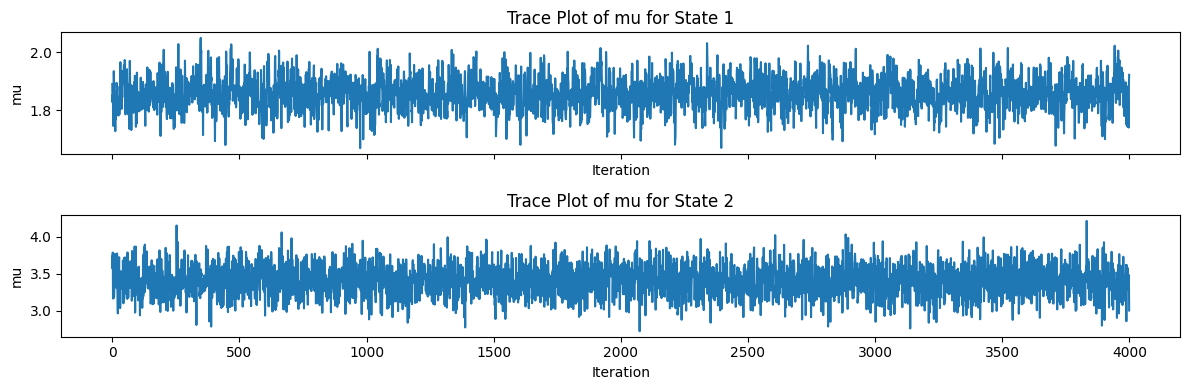

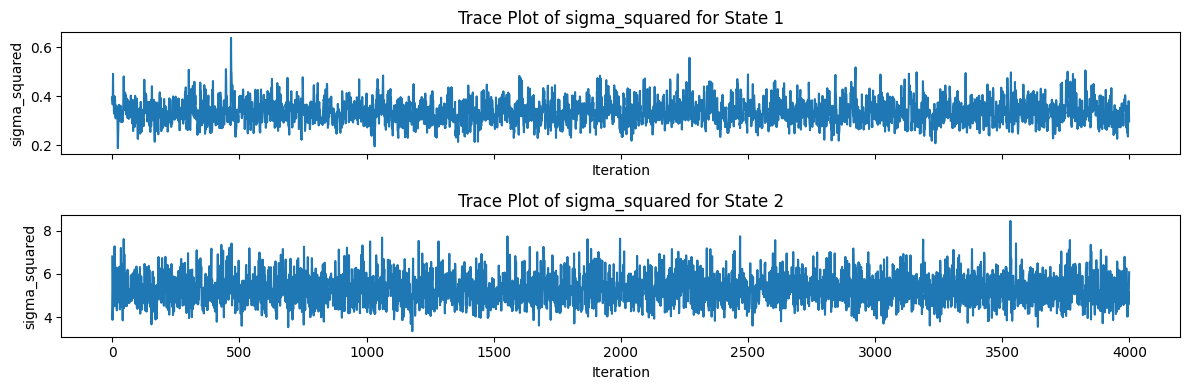

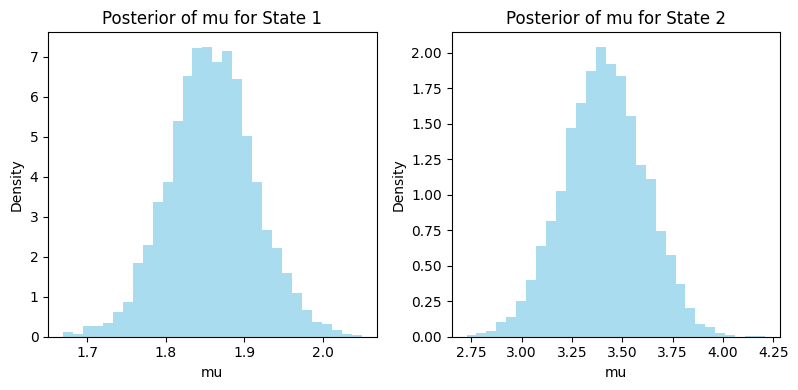

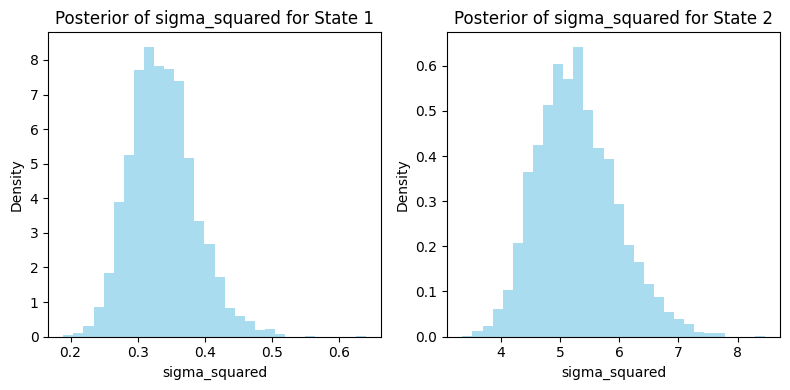

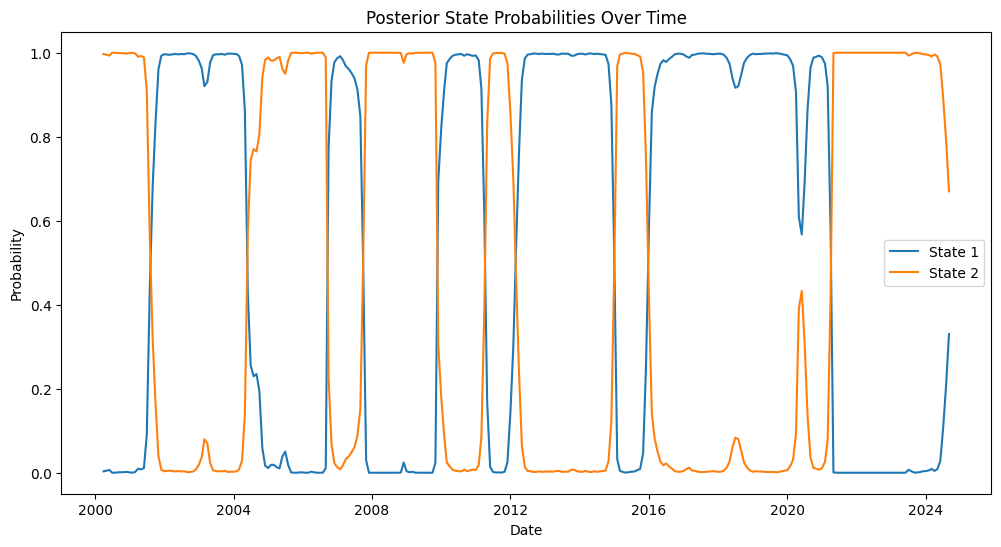

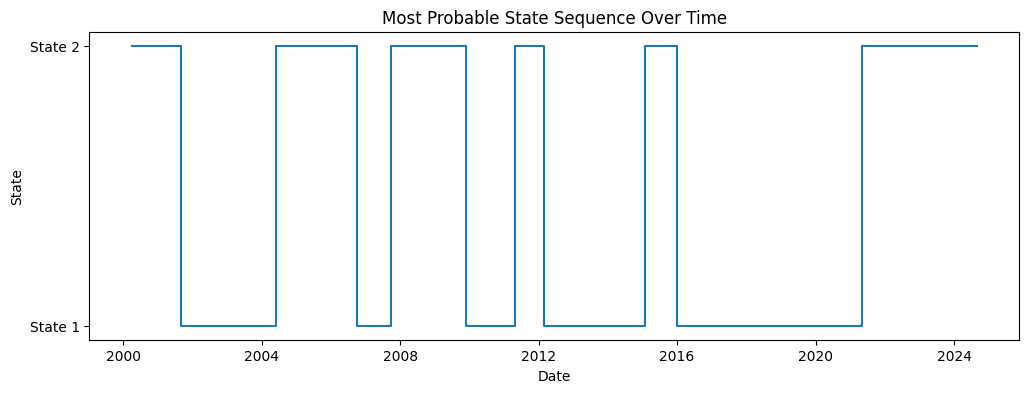

Estimated Transition Matrix (A):
P(State 1 -> State 1) = 0.9308
P(State 1 -> State 2) = 0.0692
P(State 2 -> State 1) = 0.0825
P(State 2 -> State 2) = 0.9175


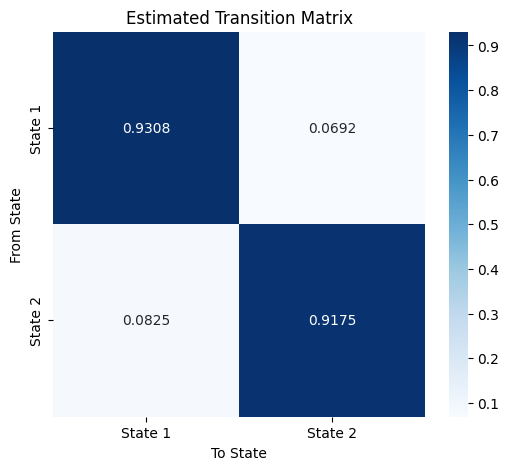

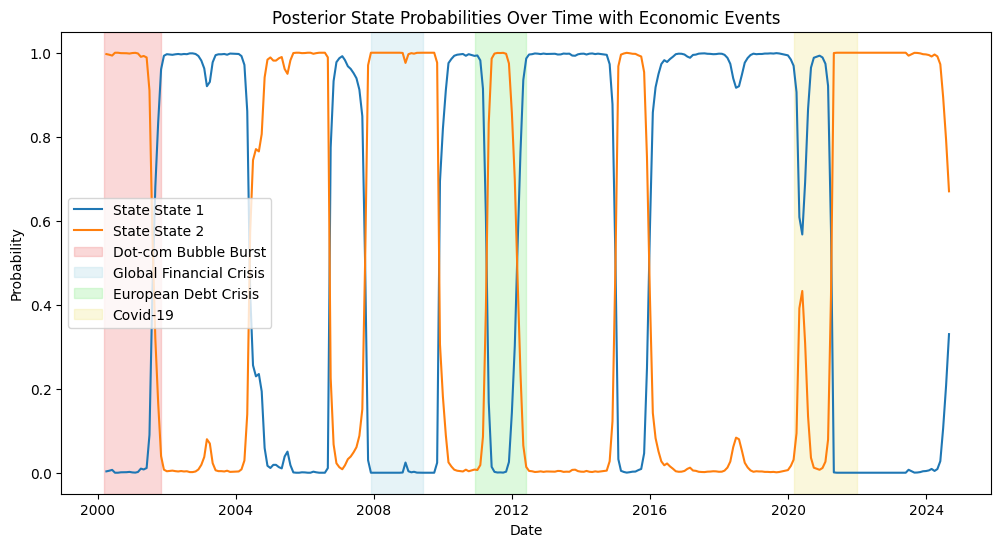

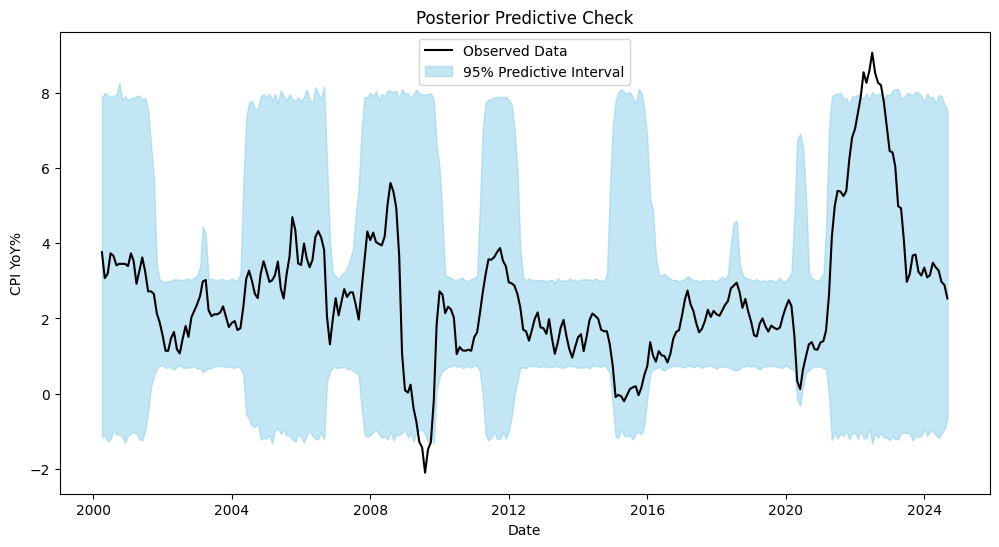

In [13]:
# Example usage:
Y = store["USA"]['CPI_YoY%'].values
K = 2
num_iter = 5000
burn_in = 1000

USA_CPI_samples = bayesian_hmm_gibbs_sampler(Y, K, num_iter, burn_in)
num_USA_CPI_samples = len(USA_CPI_samples['S'])
T = len(Y)

# Initialize an array to store predicted Y_t for each sample
Y_pred_USA_CPI_samples = np.zeros((num_USA_CPI_samples, T))

for s in range(num_USA_CPI_samples):
    mu_s = USA_CPI_samples['mu'][s]  # Emission means for sample s (array of shape (K,))
    S_s = USA_CPI_samples['S'][s]    # Hidden states for sample s (array of shape (T,))
    # Predicted values for sample s
    Y_pred_USA_CPI_samples[s, :] = mu_s[S_s]
    
# Compute the posterior predictive mean for each time point
Y_pred_mean = np.mean(Y_pred_USA_CPI_samples, axis=0)

# Compute residuals
residuals = Y - Y_pred_mean
residuals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(T), residuals, marker='o')
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.axhline(0, color='red', linestyle='--')
plt.show()
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, density=True, alpha=0.7, color='skyblue')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Density')
plt.show()
import scipy.stats as stats

plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(Y_pred_mean, residuals)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.show()
# Convert lists to NumPy arrays
pi_USA_CPI_samples = np.array(USA_CPI_samples['pi'])          # Shape: (num_USA_CPI_samples, K)
A_USA_CPI_samples = np.array(USA_CPI_samples['A'])            # Shape: (num_USA_CPI_samples, K, K)
mu_USA_CPI_samples = np.array(USA_CPI_samples['mu'])          # Shape: (num_USA_CPI_samples, K)
sigma_squared_USA_CPI_samples = np.array(USA_CPI_samples['sigma_squared'])  # Shape: (num_USA_CPI_samples, K)
S_USA_CPI_samples = np.array(USA_CPI_samples['S'])            # Shape: (num_USA_CPI_samples, T)
# Number of USA_CPI_samples after burn-in
num_USA_CPI_samples = pi_USA_CPI_samples.shape[0]
K = mu_USA_CPI_samples.shape[1]

# Initialize dictionaries to store results
posterior_means = {}
credible_intervals = {}

# For each parameter
posterior_means['pi'] = np.mean(pi_USA_CPI_samples, axis=0)
posterior_means['A'] = np.mean(A_USA_CPI_samples, axis=0)
posterior_means['mu'] = np.mean(mu_USA_CPI_samples, axis=0)
posterior_means['sigma_squared'] = np.mean(sigma_squared_USA_CPI_samples, axis=0)

# Compute 95% credible intervals
credible_intervals['pi'] = np.percentile(pi_USA_CPI_samples, [2.5, 97.5], axis=0)
credible_intervals['A'] = np.percentile(A_USA_CPI_samples, [2.5, 97.5], axis=0)
credible_intervals['mu'] = np.percentile(mu_USA_CPI_samples, [2.5, 97.5], axis=0)
credible_intervals['sigma_squared'] = np.percentile(sigma_squared_USA_CPI_samples, [2.5, 97.5], axis=0)
# Function to print the results neatly
def print_posterior_estimates():
    print("Posterior Estimates:")
    print("--------------------")
    # Initial State Distribution
    print("Initial State Distribution (pi):")
    for k in range(K):
        print(f"State {k+1}: Mean = {posterior_means['pi'][k]:.4f}, 95% CI = [{credible_intervals['pi'][0][k]:.4f}, {credible_intervals['pi'][1][k]:.4f}]")
    print("\nTransition Matrix (A):")
    for i in range(K):
        for j in range(K):
            print(f"A[{i+1}][{j+1}]: Mean = {posterior_means['A'][i][j]:.4f}, 95% CI = [{credible_intervals['A'][0][i][j]:.4f}, {credible_intervals['A'][1][i][j]:.4f}]")
    print("\nEmission Means (mu):")
    for k in range(K):
        print(f"State {k+1}: Mean = {posterior_means['mu'][k]:.4f}, 95% CI = [{credible_intervals['mu'][0][k]:.4f}, {credible_intervals['mu'][1][k]:.4f}]")
    print("\nEmission Variances (sigma_squared):")
    for k in range(K):
        print(f"State {k+1}: Mean = {posterior_means['sigma_squared'][k]:.4f}, 95% CI = [{credible_intervals['sigma_squared'][0][k]:.4f}, {credible_intervals['sigma_squared'][1][k]:.4f}]")

print_posterior_estimates()
# Function to plot trace plots
def plot_trace(parameter_USA_CPI_samples, parameter_name, state_labels):
    num_states = parameter_USA_CPI_samples.shape[1]
    fig, axes = plt.subplots(num_states, 1, figsize=(12, 2*num_states), sharex=True)
    if num_states == 1:
        axes = [axes]
    for k in range(num_states):
        axes[k].plot(parameter_USA_CPI_samples[:, k])
        axes[k].set_title(f'Trace Plot of {parameter_name} for State {state_labels[k]}')
        axes[k].set_xlabel('Iteration')
        axes[k].set_ylabel(f'{parameter_name}')
    plt.tight_layout()
    plt.show()

state_labels = [str(k+1) for k in range(K)]
# Plot trace plots for mu
plot_trace(mu_USA_CPI_samples, 'mu', state_labels)
# Plot trace plots for sigma_squared
plot_trace(sigma_squared_USA_CPI_samples, 'sigma_squared', state_labels)
# Function to plot histograms
def plot_posterior_histogram(parameter_USA_CPI_samples, parameter_name, state_labels):
    num_states = parameter_USA_CPI_samples.shape[1]
    fig, axes = plt.subplots(1, num_states, figsize=(4*num_states, 4))
    if num_states == 1:
        axes = [axes]
    for k in range(num_states):
        axes[k].hist(parameter_USA_CPI_samples[:, k], bins=30, density=True, alpha=0.7, color='skyblue')
        axes[k].set_title(f'Posterior of {parameter_name} for State {state_labels[k]}')
        axes[k].set_xlabel(f'{parameter_name}')
        axes[k].set_ylabel('Density')
    plt.tight_layout()
    plt.show()

# Plot posterior histograms for mu
plot_posterior_histogram(mu_USA_CPI_samples, 'mu', state_labels)
# Plot posterior histograms for sigma_squared
plot_posterior_histogram(sigma_squared_USA_CPI_samples, 'sigma_squared', state_labels)
# Number of time points
T = S_USA_CPI_samples.shape[1]

# Initialize an array to hold state probabilities
state_probs = np.zeros((T, K))

# For each time point, compute the fraction of USA_CPI_samples where S_t = k
for t in range(T):
    for k in range(K):
        state_probs[t, k] = np.mean(S_USA_CPI_samples[:, t] == k)

# Plot the state probabilities over time
def plot_state_probabilities(state_probs, dates, state_labels):
    plt.figure(figsize=(12, 6))
    for k in range(K):
        plt.plot(dates, state_probs[:, k], label=f'State {state_labels[k]}')
    plt.title('Posterior State Probabilities Over Time')
    plt.xlabel('Date')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

# Assuming you have a 'Period' column with dates
dates = store["Eurozone"]['Period'].values[:T]  # Ensure dates match the length T

plot_state_probabilities(state_probs, dates, state_labels)
# Determine the most probable state at each time point
most_probable_states = np.argmax(state_probs, axis=1)

# Map state indices to labels (if necessary)
state_labels = [f'State {k+1}' for k in range(K)]
state_sequence = [state_labels[state] for state in most_probable_states]

# Plot the most probable state sequence over time
def plot_most_probable_states(most_probable_states, dates, state_labels):
    plt.figure(figsize=(12, 4))
    plt.plot(dates, most_probable_states + 1, drawstyle='steps-post')
    plt.yticks(range(1, K+1), state_labels)
    plt.title('Most Probable State Sequence Over Time')
    plt.xlabel('Date')
    plt.ylabel('State')
    plt.show()

plot_most_probable_states(most_probable_states, dates, state_labels)
# Compute the posterior mean of the transition matrix
A_mean = posterior_means['A']

print("Estimated Transition Matrix (A):")
for i in range(K):
    for j in range(K):
        print(f"P(State {i+1} -> State {j+1}) = {A_mean[i][j]:.4f}")

# Visualize the transition matrix as a heatmap
import seaborn as sns

def plot_transition_matrix(A_mean, state_labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(A_mean, annot=True, cmap='Blues', fmt='.4f',
                xticklabels=state_labels, yticklabels=state_labels)
    plt.title('Estimated Transition Matrix')
    plt.xlabel('To State')
    plt.ylabel('From State')
    plt.show()

plot_transition_matrix(A_mean, state_labels)
import matplotlib.pyplot as plt
import pandas as pd

# Example events with start and end dates
events = [
    {'name': 'Dot-com Bubble Burst', 'start': '2000-03-01', 'end': '2001-11-01'},
    {'name': 'Global Financial Crisis', 'start': '2007-12-01', 'end': '2009-06-01'},
    {'name': 'European Debt Crisis', 'start': '2010-12-01', 'end': '2012-06-01'},
    {'name': 'Covid-19', 'start': '2020-03-01', 'end': '2022-01-01'}
    # Add more events as needed
]

# Define a list of colors to cycle through for each event
event_colors = ['lightcoral', 'lightblue', 'lightgreen', 'khaki', 'plum']  # Add more colors if needed

def plot_state_probabilities_with_events(state_probs, dates, state_labels, events):
    plt.figure(figsize=(12, 6))
    
    # Plot state probabilities
    for k in range(len(state_labels)):
        plt.plot(dates, state_probs[:, k], label=f'State {state_labels[k]}')
    
    # Plot events with different colors
    for i, event in enumerate(events):
        color = event_colors[i % len(event_colors)]  # Cycle through colors if more events than colors
        plt.axvspan(pd.to_datetime(event['start']), pd.to_datetime(event['end']),
                    color=color, alpha=0.3, label=event['name'])
    
    plt.title('Posterior State Probabilities Over Time with Economic Events')
    plt.xlabel('Date')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

plot_state_probabilities_with_events(state_probs, dates, state_labels, events)
# Generate synthetic data using posterior USA_CPI_samples
def generate_synthetic_data(mu_USA_CPI_samples, sigma_squared_USA_CPI_samples, S_USA_CPI_samples):
    num_USA_CPI_samples = mu_USA_CPI_samples.shape[0]
    T = S_USA_CPI_samples.shape[1]
    synthetic_Y = np.zeros((num_USA_CPI_samples, T))
    for i in range(num_USA_CPI_samples):
        mu = mu_USA_CPI_samples[i]
        sigma = np.sqrt(sigma_squared_USA_CPI_samples[i])
        S = S_USA_CPI_samples[i]
        for t in range(T):
            state = S[t]
            synthetic_Y[i, t] = np.random.normal(mu[state], sigma[state])
    return synthetic_Y

synthetic_Y = generate_synthetic_data(mu_USA_CPI_samples, sigma_squared_USA_CPI_samples, S_USA_CPI_samples)

# Compare observed data with synthetic data
def plot_posterior_predictive_check(Y_observed, synthetic_Y, dates):
    plt.figure(figsize=(12, 6))
    # Plot observed data
    plt.plot(dates, Y_observed, label='Observed Data', color='black')
    # Plot a range (e.g., 95% credible interval) of synthetic data
    lower = np.percentile(synthetic_Y, 2.5, axis=0)
    upper = np.percentile(synthetic_Y, 97.5, axis=0)
    plt.fill_between(dates, lower, upper, color='skyblue', alpha=0.5, label='95% Predictive Interval')
    plt.title('Posterior Predictive Check')
    plt.xlabel('Date')
    plt.ylabel('CPI YoY%')
    plt.legend()
    plt.show()

Y_observed = Y[:T]  # Ensure Y_observed matches length T
plot_posterior_predictive_check(Y_observed, synthetic_Y, dates)


In [42]:
# Example usage
num_particles = 1000  # Adjust the number of particles as needed
T = len(Y)

# Extract posterior means of parameters from your USA_CPI_samples
pi_mean = np.mean(USA_CPI_samples['pi'], axis=0)
A_mean = np.mean(USA_CPI_samples['A'], axis=0)

if 'mu' in USA_CPI_samples and 'sigma_squared' in USA_CPI_samples:
    # Gaussian emissions
    mu_mean = np.mean(USA_CPI_samples['mu'], axis=0)
    sigma_mean = np.sqrt(np.mean(USA_CPI_samples['sigma_squared'], axis=0))
    emission_params = {'mu': mu_mean, 'sigma': sigma_mean}
elif 'xi' in USA_CPI_samples and 'omega_squared' in USA_CPI_samples and 'alpha' in USA_CPI_samples:
    # Skew-normal emissions
    xi_mean = np.mean(USA_CPI_samples['xi'], axis=0)
    omega_mean = np.sqrt(np.mean(USA_CPI_samples['omega_squared'], axis=0))
    alpha_mean = np.mean(USA_CPI_samples['alpha'], axis=0)
    emission_params = {'xi': xi_mean, 'omega': omega_mean, 'alpha': alpha_mean}
else:
    raise ValueError("Emission parameters are not available.")

# Run the particle filter
USA_CPI_particles, USA_CPI_weights, USA_CPI_estimated_states = particle_filter(Y, pi_mean, A_mean, emission_params, num_particles)

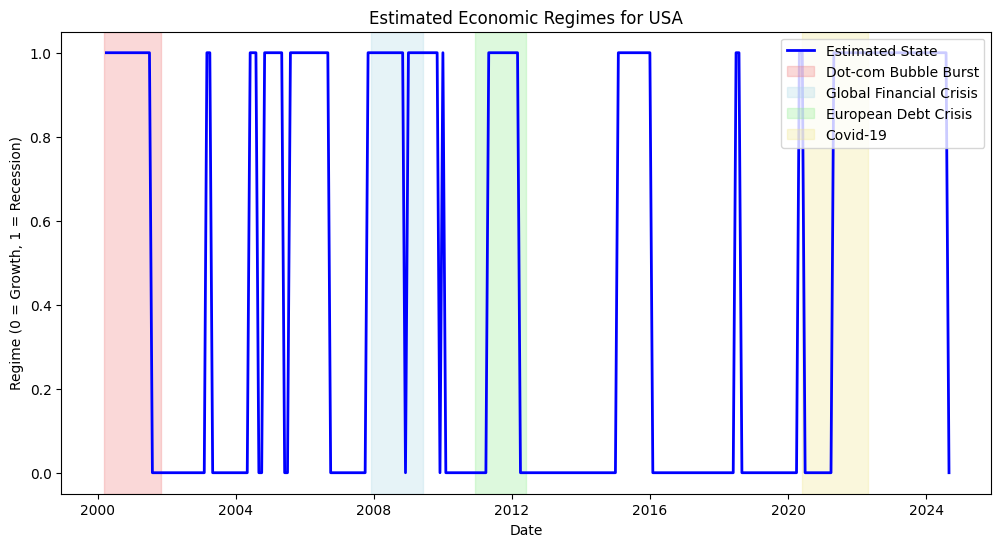

In [43]:
event_colors = ['lightcoral', 'lightblue', 'lightgreen', 'khaki', 'plum']  # Add more colors if needed


def plot_estimated_states(dates, estimated_states, events, country_name):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, estimated_states, label="Estimated State", color="blue", linewidth=2)
    
    # Highlight major financial events
    for i, event in enumerate(events):
        plt.axvspan(pd.to_datetime(event['start']), pd.to_datetime(event['end']), 
                    color=event_colors[i%len(event_colors)], alpha=0.3, label=event['name'])
    
    plt.title(f"Estimated Economic Regimes for {country_name}")
    plt.xlabel("Date")
    plt.ylabel("Regime (0 = Growth, 1 = Recession)")
    plt.legend(loc="upper right")
    plt.show()

# Example financial events
events = [
    {'name': 'Dot-com Bubble Burst', 'start': '2000-03-01', 'end': '2001-11-01'},
    {'name': 'Global Financial Crisis', 'start': '2007-12-01', 'end': '2009-06-01'},
    {'name': 'European Debt Crisis', 'start': '2010-12-01', 'end': '2012-06-01'},
    {'name': 'Covid-19', 'start': '2020-06-01', 'end': '2022-05-01'}
    # Add more events as needed
]

# Call the function with dates, estimated states, events, and country name
plot_estimated_states(dates=usa_data["Period"], estimated_states=USA_CPI_estimated_states, events=events, country_name="USA")

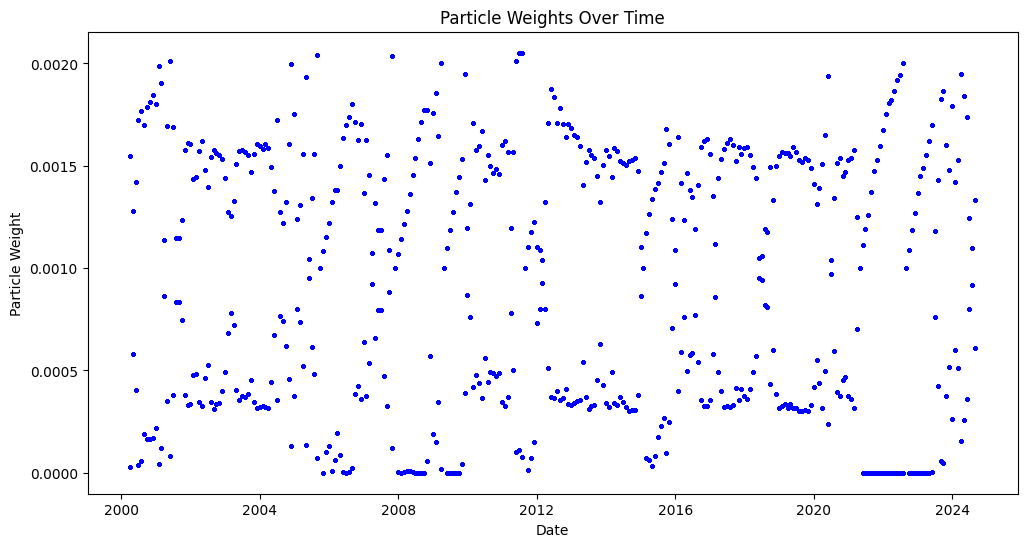

In [44]:
def plot_particle_weights(weights, dates):
    T = weights.shape[0]
    plt.figure(figsize=(12, 6))
    
    # Plot the weights for each particle over time
    for t in range(T):
        plt.plot([dates[t]] * weights.shape[1], weights[t], 'o', markersize=2, color='blue', alpha=0.2)
    
    plt.title("Particle Weights Over Time")
    plt.xlabel("Date")
    plt.ylabel("Particle Weight")
    plt.show()

# Assuming weights_eurozone has shape (T, num_particles)
plot_particle_weights(weights=USA_CPI_weights, dates=eurozone_data["Period"])

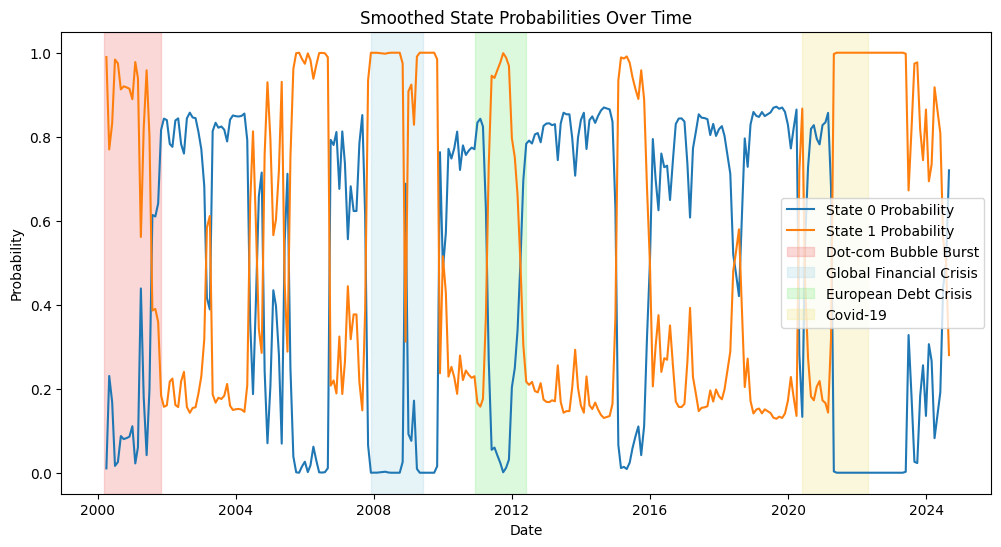

In [45]:
# Example financial events
events = [
    {'name': 'Dot-com Bubble Burst', 'start': '2000-03-01', 'end': '2001-11-01'},
    {'name': 'Global Financial Crisis', 'start': '2007-12-01', 'end': '2009-06-01'},
    {'name': 'European Debt Crisis', 'start': '2010-12-01', 'end': '2012-06-01'},
    {'name': 'Covid-19', 'start': '2020-06-01', 'end': '2022-05-01'}
    # Add more events as needed
]
event_colors = ['lightcoral', 'lightblue', 'lightgreen', 'khaki', 'plum']  # Add more colors if needed


def plot_smoothed_state_probabilities(weights, particles, dates, K):
    T = len(dates)
    state_probs = np.zeros((T, K))
    
    for t in range(T):
        for k in range(K):
            state_probs[t, k] = np.sum(weights[t][particles[t] == k])
        state_probs[t] /= np.sum(state_probs[t])  # Normalize

    
    plt.figure(figsize=(12, 6))
    for k in range(K):
        plt.plot(dates, state_probs[:, k], label=f"State {k} Probability")
    for i, event in enumerate(events):
        plt.axvspan(pd.to_datetime(event['start']), pd.to_datetime(event['end']), 
                color=event_colors[i%len(event_colors)], alpha=0.3, label=event['name'])
    
    plt.title("Smoothed State Probabilities Over Time")
    plt.xlabel("Date")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()

# Call the function to plot smoothed probabilities
plot_smoothed_state_probabilities(weights=USA_CPI_weights, particles=USA_CPI_particles, dates=usa_data["Period"], K=2)

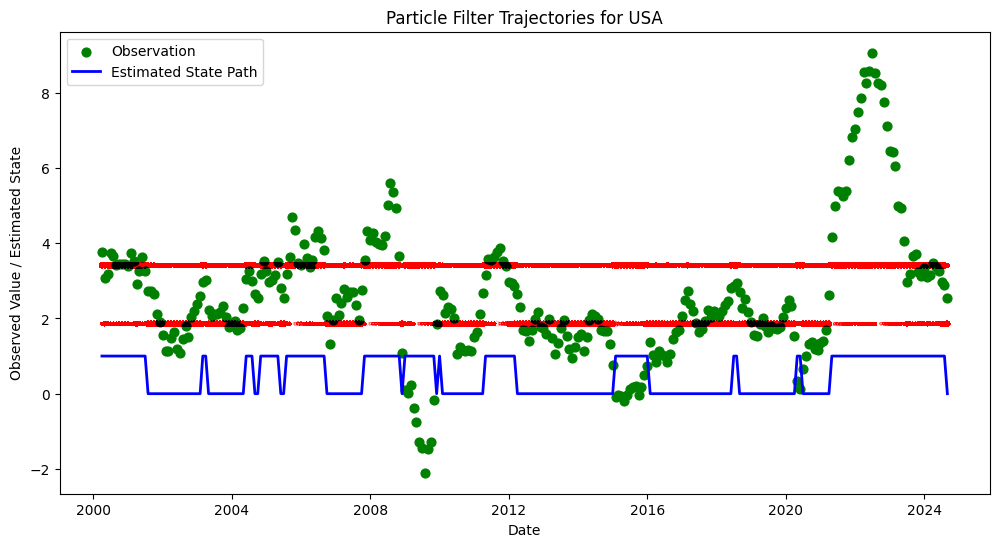

In [46]:
def plot_particle_trajectories(Y, dates, particles, weights, estimated_states, country_name):
    T, num_particles = particles.shape
    particle_trajectories = np.zeros((T, num_particles))

    # Compute particle trajectories
    for t in range(T):
        particle_trajectories[t, :] = [emission_params['mu'][particles[t, i]] for i in range(num_particles)]
    
    plt.figure(figsize=(12, 6))

    # Plot observations (actual Y values)
    plt.scatter(dates, Y, label="Observation", color="green", s=40)

    # Plot estimated states as line
    plt.plot(dates, estimated_states, label="Estimated State Path", color="blue", linewidth=2)

    # Plot particles and trajectories
    for t in range(T):
        normalized_weights = weights[t] / np.max(weights[t])
        plt.scatter([dates[t]] * num_particles, particle_trajectories[t, :], 
                    color='red', alpha=0.005, s=10 * normalized_weights + 5)
    
    plt.title(f"Particle Filter Trajectories for {country_name}")
    plt.xlabel("Date")
    plt.ylabel("Observed Value / Estimated State")
    plt.legend()
    plt.show()

# Call the function with the actual data and filter results
plot_particle_trajectories(Y=Y, dates=usa_data['Period'], 
                           particles=USA_CPI_particles, weights=USA_CPI_weights, 
                           estimated_states=USA_CPI_estimated_states, country_name="USA")

TRYING TO SIMULATE A STOCK PRICE PATH

In [49]:
import numpy as np
from scipy.stats import norm

def online_particle_filter_step(Y_i, pi, A, emission_params, particles, weights, num_particles, ess_threshold=0.5):
    """
    Perform a single update step in the particle filter for online estimation.

    Parameters:
    - Y_i: The latest observation (CPI or GDP value at time step i).
    - pi: Initial state distribution.
    - A: Transition matrix.
    - emission_params: Dictionary containing emission parameters (e.g., mu and sigma).
    - particles: Array of particles from the previous time step (1D array of length num_particles).
    - weights: Array of weights from the previous time step (1D array of length num_particles).
    - num_particles: Number of particles.
    - ess_threshold: Threshold for effective sample size to trigger resampling.

    Returns:
    - particles: Updated particle states for the current time step.
    - weights: Updated weights for the current time step.
    - estimated_state: Estimated state for the current time step.
    """
    K = len(pi)  # Number of states

    # Calculate ESS
    ess = 1.0 / np.sum(weights ** 2)
    
    # Resample if ESS falls below the threshold
    if ess < ess_threshold * num_particles:
        indices = np.random.choice(num_particles, size=num_particles, p=weights)
        particles = particles[indices]
        weights = np.ones(num_particles) / num_particles  # Reset weights to uniform after resampling
    
    # Predict step: sample next state for each particle
    particles = np.array([np.random.choice(K, p=A[particles[i]]) for i in range(num_particles)])

    # Update weights based on the new observation likelihood
    weights = norm.pdf(Y_i, loc=emission_params['mu'][particles], scale=emission_params['sigma'][particles])
    weights /= np.sum(weights)  # Normalize weights
    
    # Estimate the current state (most probable state)
    estimated_state = np.argmax(np.bincount(particles, weights=weights))
    
    return particles, weights, estimated_state

def simulate_stock_price_path(S0, mu, sigma, T, num_steps):
    """
    Simulate a stock price path using Geometric Brownian Motion (GBM).

    Parameters:
    - S0: Initial stock price.
    - mu: Expected return (drift).
    - sigma: Volatility (for the current regime).
    - T: Total time horizon (e.g., 1 year).
    - num_steps: Number of time steps in the simulation.

    Returns:
    - stock_prices: Array of simulated stock prices over the time horizon.
    """
    dt = T / num_steps
    stock_prices = np.zeros(num_steps + 1)
    stock_prices[0] = S0

    for t in range(1, num_steps + 1):
        Z = np.random.normal()  # Standard normal random variable
        stock_prices[t] = stock_prices[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    return stock_prices

In [ ]:
# Parameters for simulation
S0 = 100  # Initial stock price for stock A
T = 1.0  # 1-year horizon for simulation
num_steps = 252  # Daily steps (assuming 252 trading days in a year)
historical_volatility = {0: 0.2, 1: 0.4}  # Example volatilities for "Growth" and "Recession" regimes
pi = pi_mean
A= A_mean

# Initial setup for particle filter
num_particles = 1000
particles = np.random.choice(K, size=num_particles, p=pi)
weights = np.ones(num_particles) / num_particles

# Online estimation loop (for each new observation Y_i)
for i in range(len(Y)):
    # Perform particle filter update for the current observation Y[i]
    Y_i = Y[i]  # Current CPI or GDP observation
    particles, weights, estimated_state = online_particle_filter_step(
        Y_i, pi, A, emission_params, particles, weights, num_particles)

    # Get regime-specific volatility for the estimated state
    sigma = historical_volatility[estimated_state]

    # Simulate stock price path based on the current regime
    simulated_path = simulate_stock_price_path(S0, mu=0.05, sigma=sigma, T=T, num_steps=num_steps)

    # Print or plot the simulated path for analysis
    plt.plot(simulated_path, label=f"Simulated Path (Regime {estimated_state})")
    plt.title(f"Simulated Stock Price Path based on Estimated Regime at Time {i}")
    plt.xlabel("Days")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

    # Update initial stock price for the next loop, if needed
    S0 = simulated_path[-1]

In [53]:
pi_mean

array([0.33485629, 0.66514371])

In [54]:
A

array([[0.93080781, 0.06919219],
       [0.08252938, 0.91747062]])

SWITZERLAND CPI

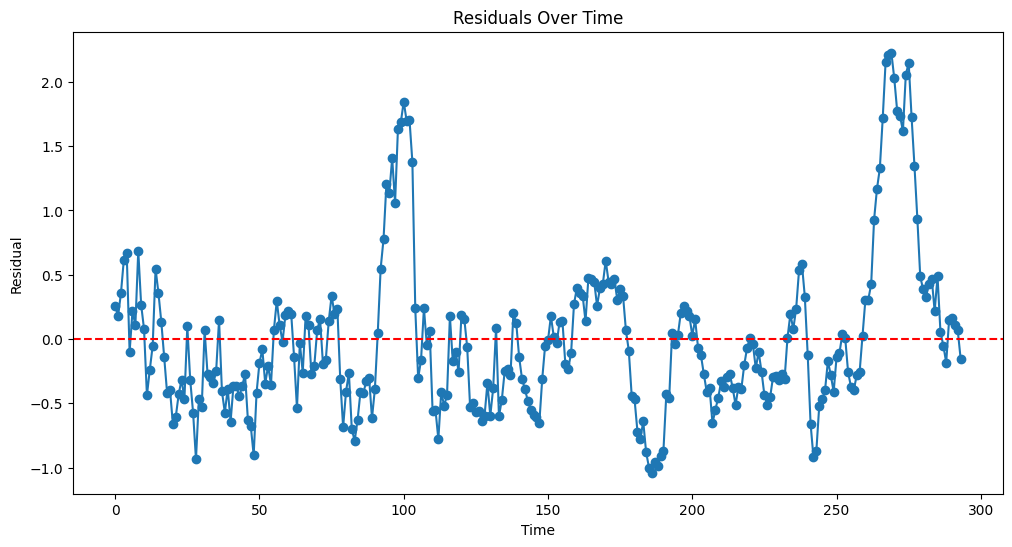

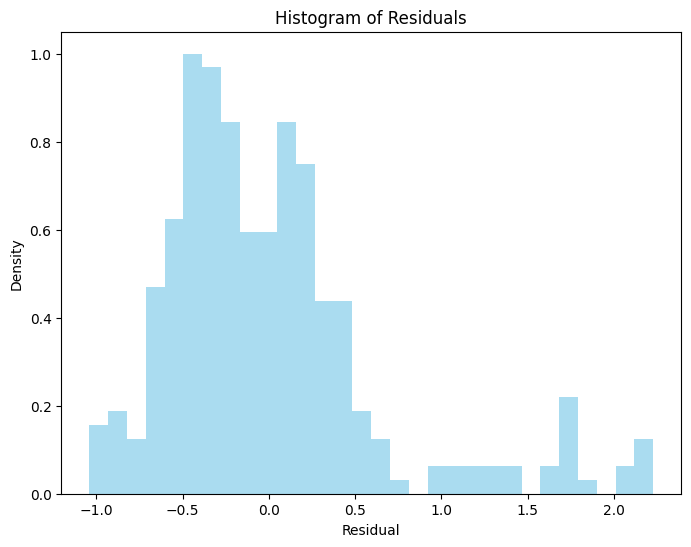

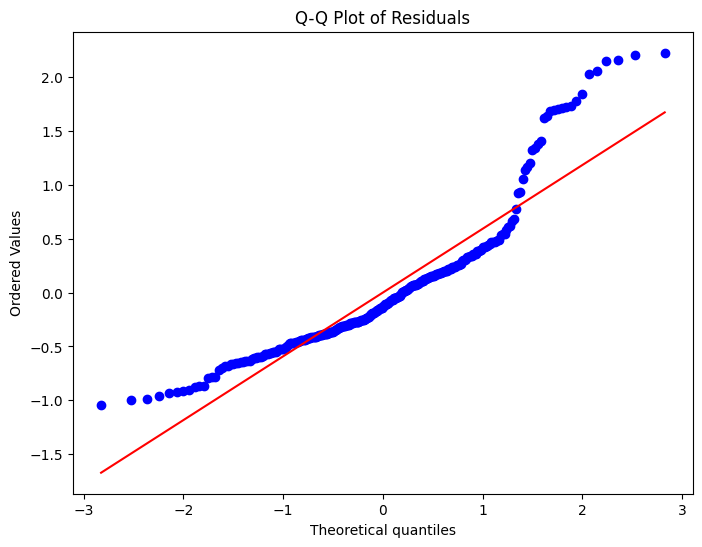

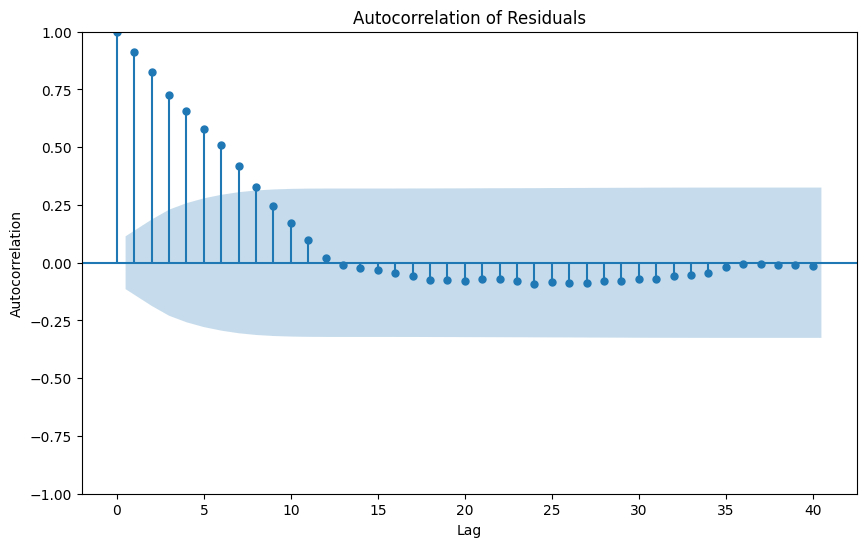

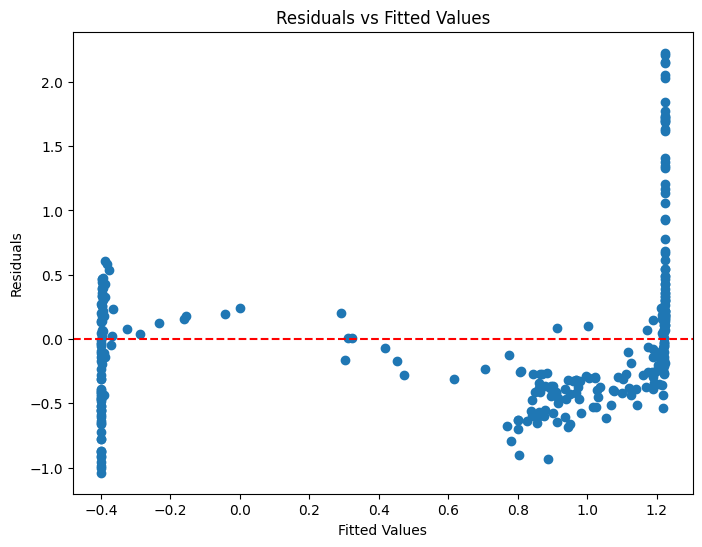

Posterior Estimates:
--------------------
Initial State Distribution (pi):
State 1: Mean = 0.3341, 95% CI = [0.0124, 0.8359]
State 2: Mean = 0.6659, 95% CI = [0.1641, 0.9876]

Transition Matrix (A):
A[1][1]: Mean = 0.9302, 95% CI = [0.8585, 0.9798]
A[1][2]: Mean = 0.0698, 95% CI = [0.0202, 0.1415]
A[2][1]: Mean = 0.0477, 95% CI = [0.0095, 0.1435]
A[2][2]: Mean = 0.9523, 95% CI = [0.8565, 0.9905]

Emission Means (mu):
State 1: Mean = -0.3999, 95% CI = [-0.5850, -0.0153]
State 2: Mean = 1.2233, 95% CI = [1.0410, 1.6051]

Emission Variances (sigma_squared):
State 1: Mean = 0.2886, 95% CI = [0.1934, 0.4477]
State 2: Mean = 0.6431, 95% CI = [0.5042, 0.7884]


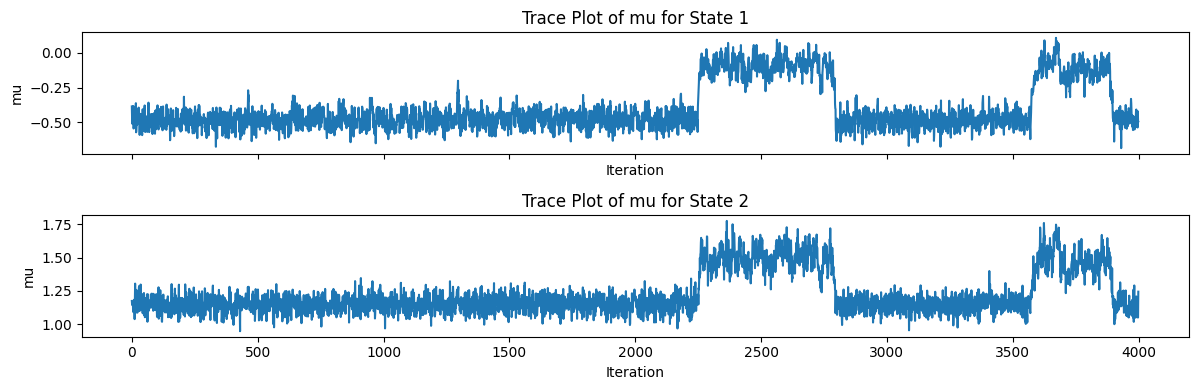

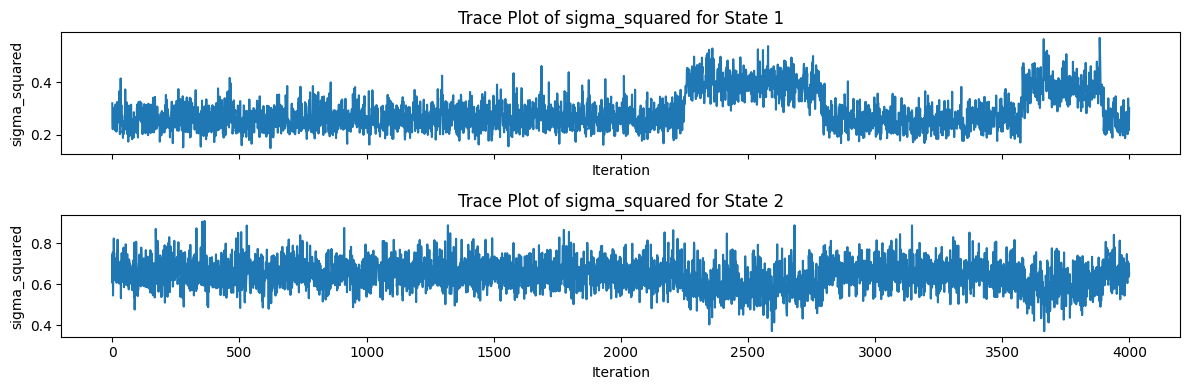

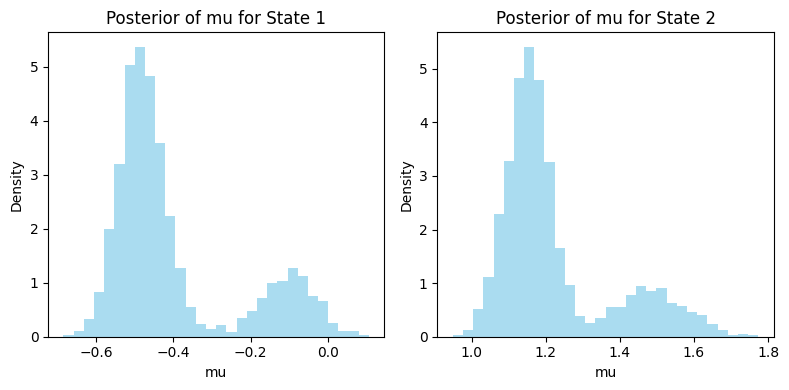

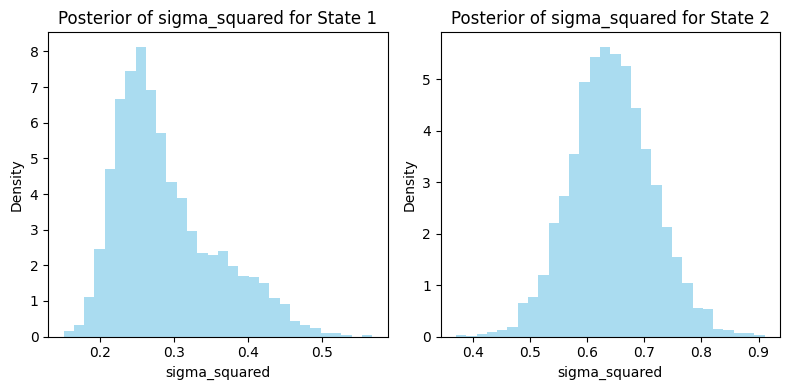

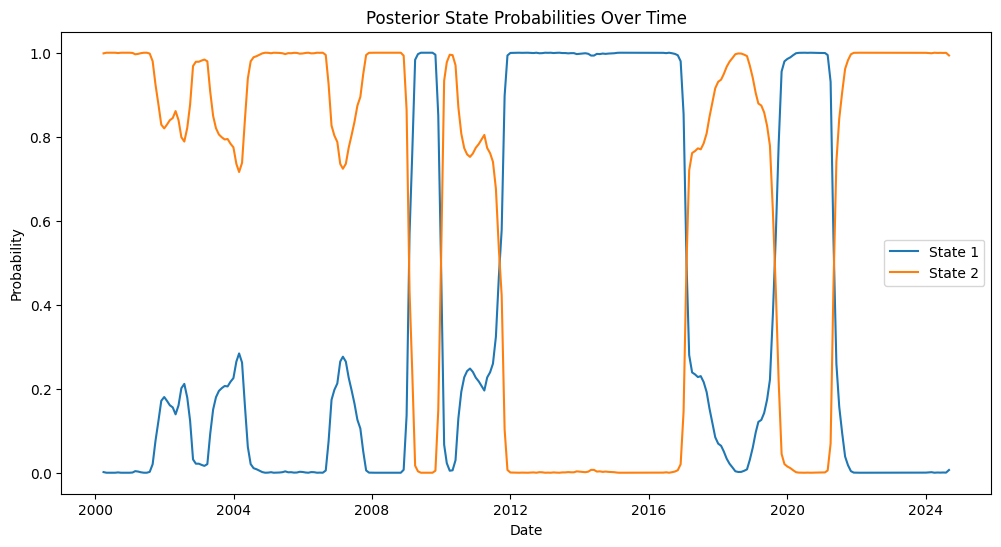

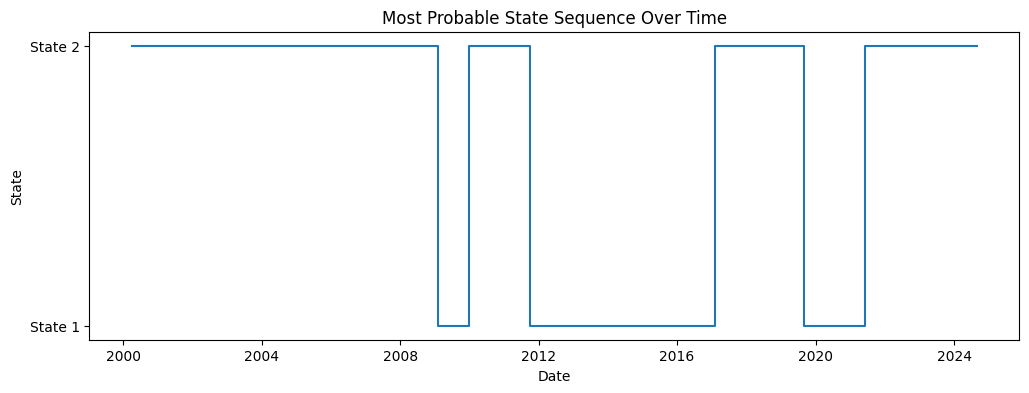

Estimated Transition Matrix (A):
P(State 1 -> State 1) = 0.9302
P(State 1 -> State 2) = 0.0698
P(State 2 -> State 1) = 0.0477
P(State 2 -> State 2) = 0.9523


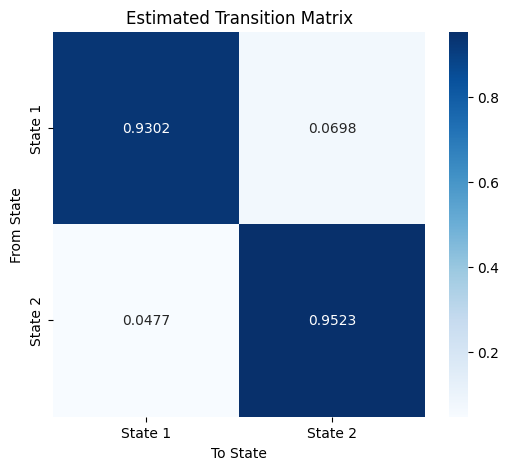

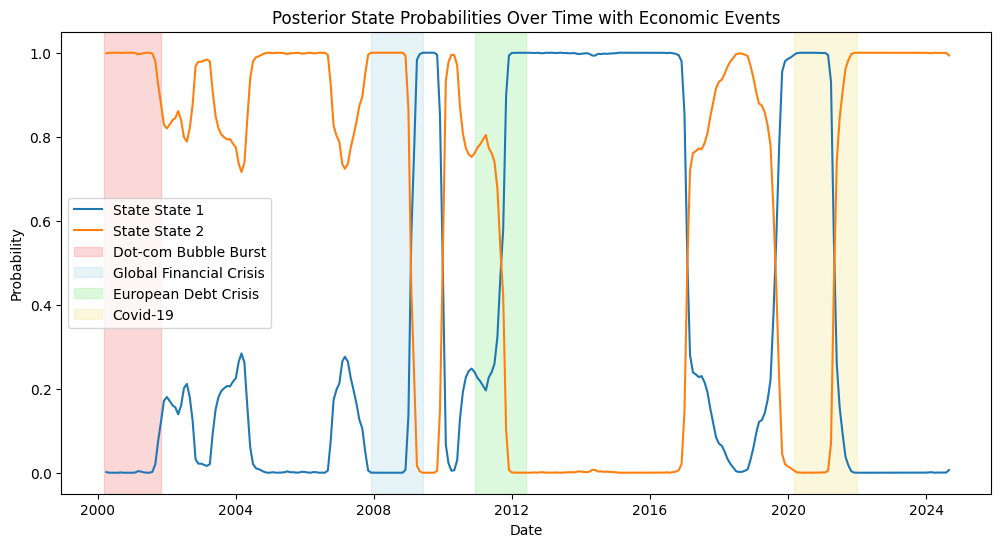

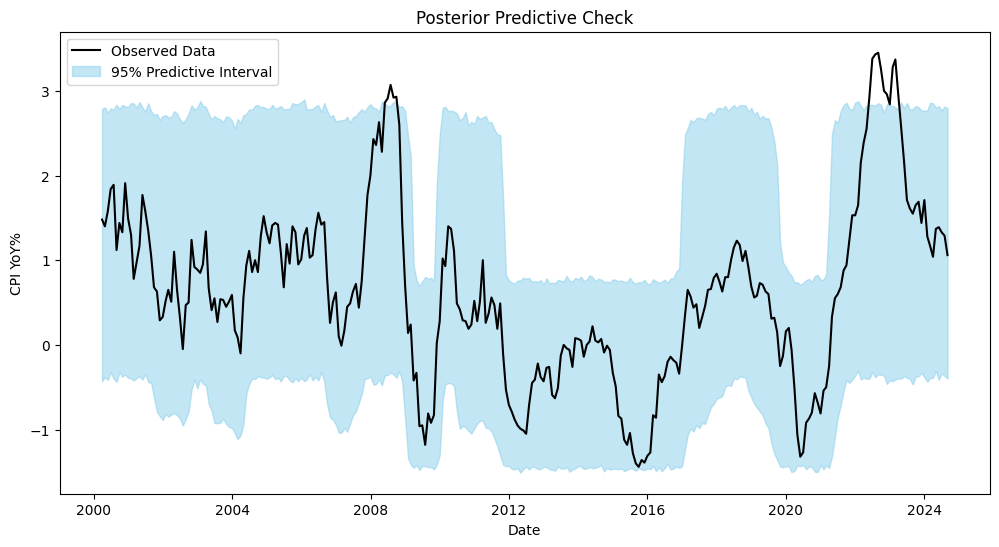

In [189]:
# Example usage:
Y = store["Switzerland"]['CPI_YoY%'].values
K = 2
num_iter = 5000
burn_in = 1000

samples = bayesian_hmm_gibbs_sampler(Y, K, num_iter, burn_in)
num_samples = len(samples['S'])
T = len(Y)

# Initialize an array to store predicted Y_t for each sample
Y_pred_samples = np.zeros((num_samples, T))

for s in range(num_samples):
    mu_s = samples['mu'][s]  # Emission means for sample s (array of shape (K,))
    S_s = samples['S'][s]    # Hidden states for sample s (array of shape (T,))
    # Predicted values for sample s
    Y_pred_samples[s, :] = mu_s[S_s]
    
# Compute the posterior predictive mean for each time point
Y_pred_mean = np.mean(Y_pred_samples, axis=0)

# Compute residuals
residuals = Y - Y_pred_mean
residuals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(T), residuals, marker='o')
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.axhline(0, color='red', linestyle='--')
plt.show()
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, density=True, alpha=0.7, color='skyblue')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Density')
plt.show()
import scipy.stats as stats

plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(Y_pred_mean, residuals)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.show()
# Convert lists to NumPy arrays
pi_samples = np.array(samples['pi'])          # Shape: (num_samples, K)
A_samples = np.array(samples['A'])            # Shape: (num_samples, K, K)
mu_samples = np.array(samples['mu'])          # Shape: (num_samples, K)
sigma_squared_samples = np.array(samples['sigma_squared'])  # Shape: (num_samples, K)
S_samples = np.array(samples['S'])            # Shape: (num_samples, T)
# Number of samples after burn-in
num_samples = pi_samples.shape[0]
K = mu_samples.shape[1]

# Initialize dictionaries to store results
posterior_means = {}
credible_intervals = {}

# For each parameter
posterior_means['pi'] = np.mean(pi_samples, axis=0)
posterior_means['A'] = np.mean(A_samples, axis=0)
posterior_means['mu'] = np.mean(mu_samples, axis=0)
posterior_means['sigma_squared'] = np.mean(sigma_squared_samples, axis=0)

# Compute 95% credible intervals
credible_intervals['pi'] = np.percentile(pi_samples, [2.5, 97.5], axis=0)
credible_intervals['A'] = np.percentile(A_samples, [2.5, 97.5], axis=0)
credible_intervals['mu'] = np.percentile(mu_samples, [2.5, 97.5], axis=0)
credible_intervals['sigma_squared'] = np.percentile(sigma_squared_samples, [2.5, 97.5], axis=0)
# Function to print the results neatly
def print_posterior_estimates():
    print("Posterior Estimates:")
    print("--------------------")
    # Initial State Distribution
    print("Initial State Distribution (pi):")
    for k in range(K):
        print(f"State {k+1}: Mean = {posterior_means['pi'][k]:.4f}, 95% CI = [{credible_intervals['pi'][0][k]:.4f}, {credible_intervals['pi'][1][k]:.4f}]")
    print("\nTransition Matrix (A):")
    for i in range(K):
        for j in range(K):
            print(f"A[{i+1}][{j+1}]: Mean = {posterior_means['A'][i][j]:.4f}, 95% CI = [{credible_intervals['A'][0][i][j]:.4f}, {credible_intervals['A'][1][i][j]:.4f}]")
    print("\nEmission Means (mu):")
    for k in range(K):
        print(f"State {k+1}: Mean = {posterior_means['mu'][k]:.4f}, 95% CI = [{credible_intervals['mu'][0][k]:.4f}, {credible_intervals['mu'][1][k]:.4f}]")
    print("\nEmission Variances (sigma_squared):")
    for k in range(K):
        print(f"State {k+1}: Mean = {posterior_means['sigma_squared'][k]:.4f}, 95% CI = [{credible_intervals['sigma_squared'][0][k]:.4f}, {credible_intervals['sigma_squared'][1][k]:.4f}]")

print_posterior_estimates()
# Function to plot trace plots
def plot_trace(parameter_samples, parameter_name, state_labels):
    num_states = parameter_samples.shape[1]
    fig, axes = plt.subplots(num_states, 1, figsize=(12, 2*num_states), sharex=True)
    if num_states == 1:
        axes = [axes]
    for k in range(num_states):
        axes[k].plot(parameter_samples[:, k])
        axes[k].set_title(f'Trace Plot of {parameter_name} for State {state_labels[k]}')
        axes[k].set_xlabel('Iteration')
        axes[k].set_ylabel(f'{parameter_name}')
    plt.tight_layout()
    plt.show()

state_labels = [str(k+1) for k in range(K)]
# Plot trace plots for mu
plot_trace(mu_samples, 'mu', state_labels)
# Plot trace plots for sigma_squared
plot_trace(sigma_squared_samples, 'sigma_squared', state_labels)
# Function to plot histograms
def plot_posterior_histogram(parameter_samples, parameter_name, state_labels):
    num_states = parameter_samples.shape[1]
    fig, axes = plt.subplots(1, num_states, figsize=(4*num_states, 4))
    if num_states == 1:
        axes = [axes]
    for k in range(num_states):
        axes[k].hist(parameter_samples[:, k], bins=30, density=True, alpha=0.7, color='skyblue')
        axes[k].set_title(f'Posterior of {parameter_name} for State {state_labels[k]}')
        axes[k].set_xlabel(f'{parameter_name}')
        axes[k].set_ylabel('Density')
    plt.tight_layout()
    plt.show()

# Plot posterior histograms for mu
plot_posterior_histogram(mu_samples, 'mu', state_labels)
# Plot posterior histograms for sigma_squared
plot_posterior_histogram(sigma_squared_samples, 'sigma_squared', state_labels)
# Number of time points
T = S_samples.shape[1]

# Initialize an array to hold state probabilities
state_probs = np.zeros((T, K))

# For each time point, compute the fraction of samples where S_t = k
for t in range(T):
    for k in range(K):
        state_probs[t, k] = np.mean(S_samples[:, t] == k)

# Plot the state probabilities over time
def plot_state_probabilities(state_probs, dates, state_labels):
    plt.figure(figsize=(12, 6))
    for k in range(K):
        plt.plot(dates, state_probs[:, k], label=f'State {state_labels[k]}')
    plt.title('Posterior State Probabilities Over Time')
    plt.xlabel('Date')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

# Assuming you have a 'Period' column with dates
dates = store["Eurozone"]['Period'].values[:T]  # Ensure dates match the length T

plot_state_probabilities(state_probs, dates, state_labels)
# Determine the most probable state at each time point
most_probable_states = np.argmax(state_probs, axis=1)

# Map state indices to labels (if necessary)
state_labels = [f'State {k+1}' for k in range(K)]
state_sequence = [state_labels[state] for state in most_probable_states]

# Plot the most probable state sequence over time
def plot_most_probable_states(most_probable_states, dates, state_labels):
    plt.figure(figsize=(12, 4))
    plt.plot(dates, most_probable_states + 1, drawstyle='steps-post')
    plt.yticks(range(1, K+1), state_labels)
    plt.title('Most Probable State Sequence Over Time')
    plt.xlabel('Date')
    plt.ylabel('State')
    plt.show()

plot_most_probable_states(most_probable_states, dates, state_labels)
# Compute the posterior mean of the transition matrix
A_mean = posterior_means['A']

print("Estimated Transition Matrix (A):")
for i in range(K):
    for j in range(K):
        print(f"P(State {i+1} -> State {j+1}) = {A_mean[i][j]:.4f}")

# Visualize the transition matrix as a heatmap
import seaborn as sns

def plot_transition_matrix(A_mean, state_labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(A_mean, annot=True, cmap='Blues', fmt='.4f',
                xticklabels=state_labels, yticklabels=state_labels)
    plt.title('Estimated Transition Matrix')
    plt.xlabel('To State')
    plt.ylabel('From State')
    plt.show()

plot_transition_matrix(A_mean, state_labels)
import matplotlib.pyplot as plt
import pandas as pd

# Example events with start and end dates
events = [
    {'name': 'Dot-com Bubble Burst', 'start': '2000-03-01', 'end': '2001-11-01'},
    {'name': 'Global Financial Crisis', 'start': '2007-12-01', 'end': '2009-06-01'},
    {'name': 'European Debt Crisis', 'start': '2010-12-01', 'end': '2012-06-01'},
    {'name': 'Covid-19', 'start': '2020-03-01', 'end': '2022-01-01'}
    # Add more events as needed
]

# Define a list of colors to cycle through for each event
event_colors = ['lightcoral', 'lightblue', 'lightgreen', 'khaki', 'plum']  # Add more colors if needed

def plot_state_probabilities_with_events(state_probs, dates, state_labels, events):
    plt.figure(figsize=(12, 6))
    
    # Plot state probabilities
    for k in range(len(state_labels)):
        plt.plot(dates, state_probs[:, k], label=f'State {state_labels[k]}')
    
    # Plot events with different colors
    for i, event in enumerate(events):
        color = event_colors[i % len(event_colors)]  # Cycle through colors if more events than colors
        plt.axvspan(pd.to_datetime(event['start']), pd.to_datetime(event['end']),
                    color=color, alpha=0.3, label=event['name'])
    
    plt.title('Posterior State Probabilities Over Time with Economic Events')
    plt.xlabel('Date')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

plot_state_probabilities_with_events(state_probs, dates, state_labels, events)
# Generate synthetic data using posterior samples
def generate_synthetic_data(mu_samples, sigma_squared_samples, S_samples):
    num_samples = mu_samples.shape[0]
    T = S_samples.shape[1]
    synthetic_Y = np.zeros((num_samples, T))
    for i in range(num_samples):
        mu = mu_samples[i]
        sigma = np.sqrt(sigma_squared_samples[i])
        S = S_samples[i]
        for t in range(T):
            state = S[t]
            synthetic_Y[i, t] = np.random.normal(mu[state], sigma[state])
    return synthetic_Y

synthetic_Y = generate_synthetic_data(mu_samples, sigma_squared_samples, S_samples)

# Compare observed data with synthetic data
def plot_posterior_predictive_check(Y_observed, synthetic_Y, dates):
    plt.figure(figsize=(12, 6))
    # Plot observed data
    plt.plot(dates, Y_observed, label='Observed Data', color='black')
    # Plot a range (e.g., 95% credible interval) of synthetic data
    lower = np.percentile(synthetic_Y, 2.5, axis=0)
    upper = np.percentile(synthetic_Y, 97.5, axis=0)
    plt.fill_between(dates, lower, upper, color='skyblue', alpha=0.5, label='95% Predictive Interval')
    plt.title('Posterior Predictive Check')
    plt.xlabel('Date')
    plt.ylabel('CPI YoY%')
    plt.legend()
    plt.show()

Y_observed = Y[:T]  # Ensure Y_observed matches length T
plot_posterior_predictive_check(Y_observed, synthetic_Y, dates)


In [207]:
store["Eurozone"]

,Period,GDP_YoY%,CPI_YoY%,Combined_Regime
0,2000-03-31,0.0426,1.96,4
1,2000-04-30,0.0426,1.71,4
2,2000-05-31,0.0426,1.76,4
3,2000-06-30,0.0467,2.14,4
4,2000-07-31,0.0467,2.09,4
...,...,...,...,...
289,2024-04-30,0.0046,2.37,3
290,2024-05-31,0.0046,2.57,3
291,2024-06-30,0.0060,2.52,3
292,2024-07-31,0.0060,2.58,3


In [202]:
# Define initial state distribution (pi), transition matrix (A), and emission parameters for each country
K = 2  # Number of hidden states (e.g., Growth, Recession)
pi = np.array([0.5, 0.5])  # Assume equal probability of starting in each state

# Define transition matrices (probabilities of switching between regimes)
A_eurozone = np.array([[0.9, 0.1], [0.2, 0.8]])  # Eurozone
A_usa = np.array([[0.85, 0.15], [0.25, 0.75]])   # USA
A_switzerland = np.array([[0.88, 0.12], [0.3, 0.7]])  # Switzerland

# Emission parameters (Gaussian means and standard deviations for each state)
# These values are hypothetical; adjust based on statistical analysis or previous parameter inference.
emission_params_eurozone = {'mu': np.array([2.0, -1.0]), 'sigma': np.array([0.5, 1.0])}
emission_params_usa = {'mu': np.array([2.5, -0.5]), 'sigma': np.array([0.6, 0.9])}
emission_params_switzerland = {'mu': np.array([1.8, -0.8]), 'sigma': np.array([0.4, 0.8])}

In [203]:
from scipy.stats import norm

def particle_filter(Y, pi, A, emission_params, num_particles, ess_threshold=0.5):
    T = len(Y)
    K = len(pi)
    particles = np.zeros((T, num_particles), dtype=int)
    weights = np.zeros((T, num_particles))
    
    # Initialize particles and weights
    particles[0] = np.random.choice(K, size=num_particles, p=pi)
    weights[0] = norm.pdf(Y[0], loc=emission_params['mu'][particles[0]], scale=emission_params['sigma'][particles[0]])
    weights[0] /= np.sum(weights[0])  # Normalize weights
    
    for t in range(1, T):
        # Calculate ESS
        ess = 1.0 / np.sum(weights[t-1] ** 2)
        
        # Resample if ESS falls below the threshold
        if ess < ess_threshold * num_particles:
            indices = np.random.choice(num_particles, size=num_particles, p=weights[t-1])
            particles[t-1] = particles[t-1][indices]
            weights[t-1] = np.ones(num_particles) / num_particles  # Reset weights to uniform after resampling
        
        particles_t_minus_1 = particles[t-1]
        
        # Predict step: sample next state for each particle
        particles[t] = np.array([np.random.choice(K, p=A[particles_t_minus_1[i]]) for i in range(num_particles)])
        
        # Update weights based on observation likelihood
        weights[t] = norm.pdf(Y[t], loc=emission_params['mu'][particles[t]], scale=emission_params['sigma'][particles[t]])
        weights[t] /= np.sum(weights[t])  # Normalize weights
    
    # Estimate states using the most probable particle at each time
    estimated_states = np.array([np.bincount(particles[t], weights=weights[t]).argmax() for t in range(T)])
    
    return particles, weights, estimated_states

In [209]:
num_particles = 5000  # Number of particles to use

# Run particle filter for Eurozone
Y_eurozone = eurozone_data['CPI_YoY%'].values
particles_eurozone, weights_eurozone, estimated_states_eurozone = particle_filter(
    Y_eurozone, pi, A_eurozone, emission_params_eurozone, num_particles)

# Run particle filter for USA
Y_usa = usa_data['CPI_YoY%'].values
particles_usa, weights_usa, estimated_states_usa = particle_filter(
    Y_usa, pi, A_usa, emission_params_usa, num_particles)

# Run particle filter for Switzerland
Y_switzerland = switzerland_data['CPI_YoY%'].values
particles_switzerland, weights_switzerland, estimated_states_switzerland = particle_filter(
    Y_switzerland, pi, A_switzerland, emission_params_switzerland, num_particles)

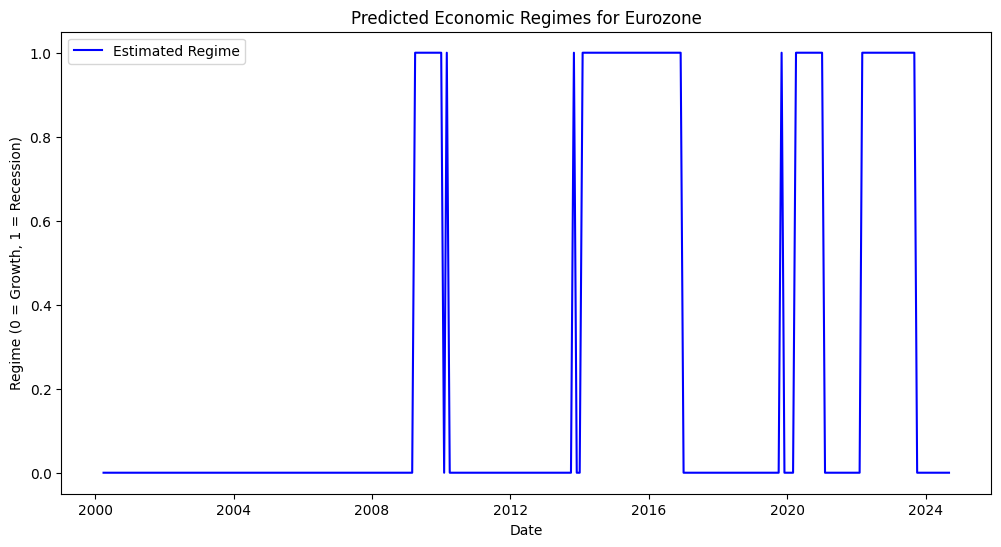

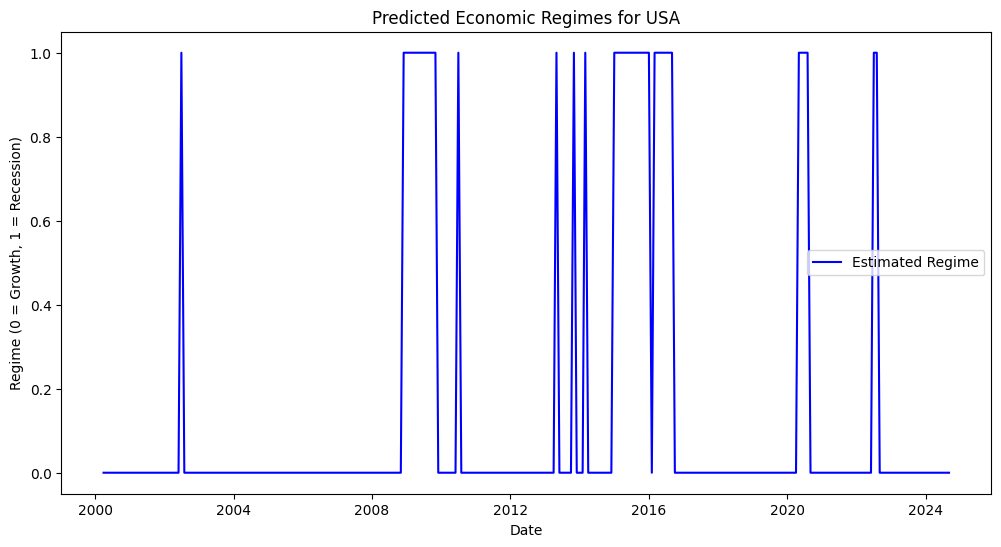

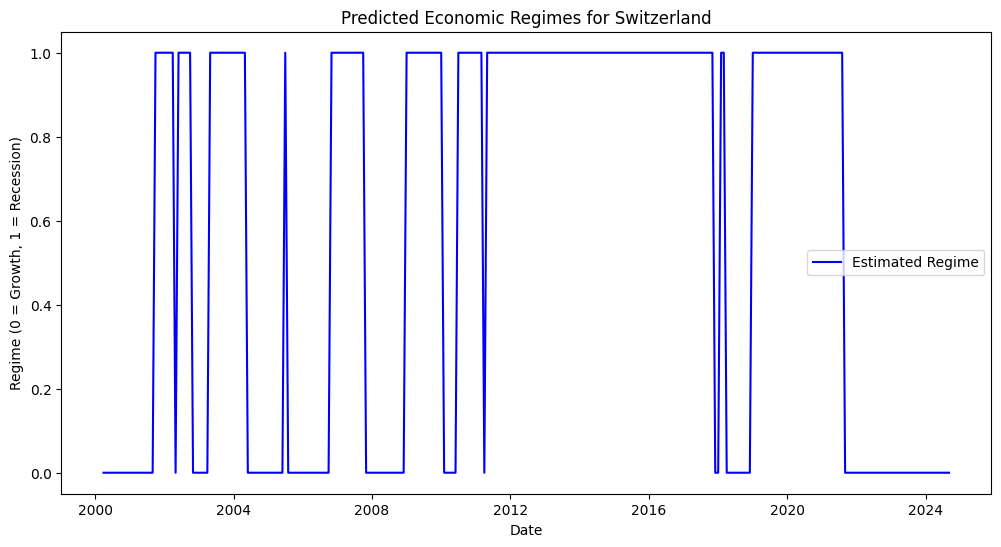

In [ ]:
# Plot events with different colors
def plot_regimes(dates, estimated_states, country):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, estimated_states, label="Estimated Regime", color="b")
    plt.title(f"Predicted Economic Regimes for {country}")
    plt.xlabel("Date")
    plt.ylabel("Regime (0 = Growth, 1 = Recession)")
    plt.legend()
    plt.show()


# Assuming we have dates available in the data
plot_regimes(eurozone_data["Period"], estimated_states_eurozone, "Eurozone")
plot_regimes(usa_data["Period"], estimated_states_usa, "USA")
plot_regimes(switzerland_data["Period"], estimated_states_switzerland, "Switzerland")